## 0. Imports

In [1]:
from bs4 import BeautifulSoup 
import requests
import pandas as pd
import numpy as np
import urllib.request
import folium
from IPython.display import Image
import lxml

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import plotly.figure_factory as ff

from sklearn import preprocessing
from sklearn import metrics
from sklearn import decomposition
from sklearn import cluster
from sklearn_extra import cluster as cluster_ex

from scipy.cluster import hierarchy

## 1. Obtaining data on districts of Bangkok from Wikipedia

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok'
data  = requests.get(url).text 
soup = BeautifulSoup(data, 'html5lib')
table = soup.find('table')
#table

In [3]:
df_geo = pd.read_html(str(table), flavor='bs4')[0]
df_geo.drop(columns = ['Thai'], inplace = True)
columns = ['District', 'MapNr', 'Postcode', 'Population', 'Subdistricts', 'Latitude', 'Longitude']
df_geo.rename(columns = {'District(Khet)' : 'District', 'Post-code' : 'Postcode', 'Popu-lation' : 'Population', 
                     'No. ofSubdis-trictsKhwaeng' : 'Subdistricts'}, inplace = True)
print(df_geo.shape)
df_geo.drop(columns = ['Population'], inplace = True)
print(df_geo.dtypes)
df_geo.head()

(50, 7)
District         object
MapNr             int64
Postcode          int64
Subdistricts      int64
Latitude        float64
Longitude       float64
dtype: object


,District,MapNr,Postcode,Subdistricts,Latitude,Longitude
0,Bang Bon,50,10150,4,13.659200,100.399100
1,Bang Kapi,6,10240,2,13.765833,100.647778
2,Bang Khae,40,10160,4,13.696111,100.409444
3,Bang Khen,5,10220,2,13.873889,100.596389
4,Bang Kho Laem,31,10120,3,13.693333,100.502500


## 2. Obtaining population data published by the BMA

In [4]:
# Load Bangkok district dataset 
url = 'http://data.bangkok.go.th/dataset/ce87c684-f08a-4351-9029-8c8e722b4f4a/resource/4ea00caf-2e96-40f7-8c2f-b00c36d376b3/download/sed_5fb47e11c79f5.csv'
filename1 = 'sed_5fb47e11c79f5.csv'
urllib.request.urlretrieve(url, filename1)
df_districts = pd.read_csv(filename1)

#display(df_districts.head())
# Load romanized district names
filename2 = 'English names.csv'
df_eng = pd.read_csv(filename2, names = ['District'])

# Replace Thai names with romanized names
df_districts = df_districts.merge(df_eng, left_index = True, right_index = True)

# Reorder columns
fixed_columns = [df_districts.columns[0]] + [df_districts.columns[-1]] + list(df_districts.columns[1:-1])
df_districts = df_districts[fixed_columns]

# Drop unneeded columns
df_districts.drop(columns = ['id','d_name','pop_male', 'pop_femal', 'house_amt', 'adddate', 'updatedate'], inplace = True)
#display(df_districts.head())

# Drop first row (for all Bangkok)
df_districts.drop(index = 0, inplace = True)

# Drop 'Subdistrict' rows
mask = df_districts['District'].str.contains(pat = 'Subdistrict')
df_districts = df_districts[~mask]

# Clean up strings in remaining columns, sort by 'District' and reset index
df_districts['District'] = df_districts['District'].apply(lambda x: x.strip())
df_districts.sort_values(by = ['District'], inplace = True)
df_districts['pop_total'].replace(',','', regex = True, inplace = True)
df_districts['pop_density'].replace(',','', regex = True, inplace = True)
df_districts['pop_density'].replace('#DIV/0!',np.nan, regex = True, inplace = True)
df_districts.reset_index(drop = True, inplace = True)

# Convert appropriate columns to numerical data, replace 0 areas by NaN
df_districts['pop_total'] = pd.to_numeric(df_districts['pop_total'])
df_districts['area_km2'] = pd.to_numeric(df_districts['area_km2'])
df_districts['pop_density'] = pd.to_numeric(df_districts['pop_density'])
df_districts['area_km2'].replace(0,np.nan, inplace = True)


print(df_districts.shape)
display(df_districts.head())
df_districts.dtypes


(50, 4)


,District,pop_total,area_km2,pop_density
0,Bang Bon,106919,NaN,NaN
1,Bang Kapi,146841,28.523,5148.0
2,Bang Khae,193315,44.456,4348.0
3,Bang Khen,191323,42.123,4542.0
4,Bang Kho Laem,88288,10.921,8084.0


District        object
pop_total        int64
area_km2       float64
pop_density    float64
dtype: object

In [5]:
# Check 'District' columns match in df_geo and df_districts (this was used to edit the csv file of romanized names)
# Since file has been edited appropriately this will now result in empty dataframes
mask = df_geo['District'] == df_districts['District']
mask
display(df_geo[~mask].head(50))
display(df_districts[~mask].head(50))

,District,MapNr,Postcode,Subdistricts,Latitude,Longitude


,District,pop_total,area_km2,pop_density


In [6]:
df_districts = df_districts.merge(df_geo)
display(df_districts.head(50))

df_districts.dtypes

,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude
0,Bang Bon,106919,NaN,NaN,50,10150,4,13.659200,100.399100
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500
5,Bang Khun Thian,183878,120.687,1524.0,21,10150,2,13.660833,100.435833
6,Bang Na,90148,NaN,NaN,47,10260,2,13.680081,100.591800
7,Bang Phlat,91278,11.360,8035.0,25,10700,4,13.793889,100.505000
8,Bang Rak,48207,5.536,8708.0,4,10500,5,13.730833,100.524167
9,Bang Sue,125299,11.545,10853.0,29,10800,2,13.809722,100.537222


District         object
pop_total         int64
area_km2        float64
pop_density     float64
MapNr             int64
Postcode          int64
Subdistricts      int64
Latitude        float64
Longitude       float64
dtype: object

In [7]:
#mask = df_districts['pop_density'].isna()
#display(df_districts[mask])

# Missing area data obtained manually from Wikipedia using mask above
areas = {'Bang Bon' : 34.745, 'Bang Na' : 18.789, 'Phaya Thai' : 9.59, 'Phra Khanong' : 13.986, 'Saphan Sung' : 28.124,
        'Suan Luang' : 23.678}

# Use dictionary to fill missing area values
df_districts['area_km2'] = df_districts['area_km2'].fillna(df_districts['District'].map(areas))


display(df_districts.head())

,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude
0,Bang Bon,106919,34.745,NaN,50,10150,4,13.659200,100.399100
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500


In [8]:
# Now fill in missing population densities using area and population data (rounding to zero decimal places for consistency)
df_districts.loc[(np.isnan(df_districts['pop_density'])), 'pop_density'] = round(df_districts['pop_total']/df_districts['area_km2'],0)
display(df_districts.head())

,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude
0,Bang Bon,106919,34.745,3077.0,50,10150,4,13.659200,100.399100
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500


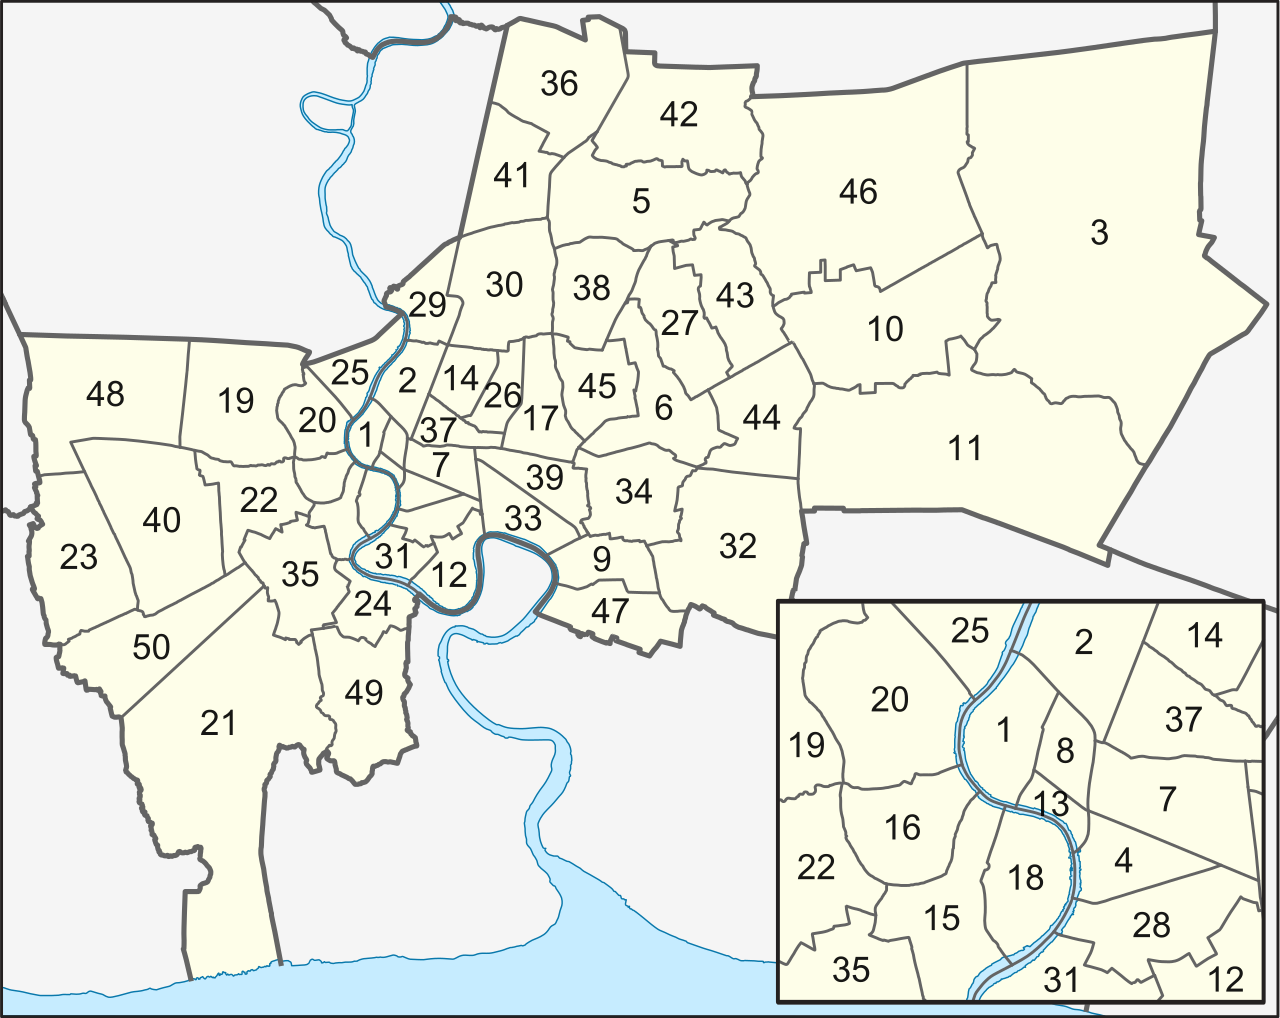

In [9]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Khet_Bangkok.svg/1280px-Khet_Bangkok.svg.png'
Image(url,width=1000, height=1000)

## 3. Obtaining community data published by the BMA

In [10]:
# Load Bangkok communities dataset 
url = 'http://data.bangkok.go.th/dataset/e57c4e2e-77c8-4994-b9d8-b2d3a67aad82/resource/a41b3558-a441-4bb2-bcde-d51cca91f4c9/download/sed_5fb48694f247f.csv'
filename = 'communities.csv'
urllib.request.urlretrieve(url, filename)
df_comm = pd.read_csv(filename)
df_comm.head()

,id,district,comm1_keha,comm2_chan,comm3_mueng,comm4_moobaan,comm5_comdo,comm6_salam,comm_total,adddate,updatedate
0,51,รวม,69,473,658,355,426,85,2066,2020-11-18,2020-11-18
1,50,ห้วยขวาง,-,1,18,-,3,1,23,2020-11-18,2020-11-18
2,49,หลักสี่,31,6,17,1,14,12,81,2020-11-18,2020-11-18
3,48,หนองจอก,1,1,-,82,13,-,97,2020-11-18,2020-11-18
4,47,หนองแขม,-,5,2,44,21,2,74,2020-11-18,2020-11-18


In [11]:
# Drop unwanted columns and first row (total for all Bangkok), and rename community type columns
df = df_comm.copy()
df.drop(0, axis = 0, inplace = True)
columns = ['id', 'comm_total','adddate', 'updatedate']
df.drop(columns, axis = 1, inplace = True)
columns = {'comm1_keha' : 'C1_gov_apt', 'comm2_chan' : 'C2_gated', 'comm3_mueng' : 'C3_slum', 
           'comm4_moobaan' : 'C4_urban', 'comm5_comdo' : 'C5_suburb', 'comm6_salam' : 'C6_high_rise'}
df.rename(columns = columns, inplace = True)

# Check data types
print(df.dtypes)

# Convert community type counts to numerical data
columns = ['C1_gov_apt', 'C2_gated', 'C3_slum', 'C4_urban', 'C5_suburb', 'C6_high_rise']
df[columns] = df[columns].replace('-', '0')
for c in columns:
    df[c] = pd.to_numeric(df[c])
print(df.dtypes)
df.reset_index(drop = True, inplace = True)
df.head()

district        object
C1_gov_apt      object
C2_gated        object
C3_slum         object
C4_urban        object
C5_suburb       object
C6_high_rise    object
dtype: object
district        object
C1_gov_apt       int64
C2_gated         int64
C3_slum          int64
C4_urban         int64
C5_suburb        int64
C6_high_rise     int64
dtype: object


,district,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise
0,ห้วยขวาง,0,1,18,0,3,1
1,หลักสี่,31,6,17,1,14,12
2,หนองจอก,1,1,0,82,13,0
3,หนองแขม,0,5,2,44,21,2
4,สายไหม,3,18,4,6,48,0


We want to add Romanized names. Fortunately for us, the Thai district names here are in the same order as the names in df_eng, so we can use that after dropping the subdistricts.

In [12]:
# Get list of only districts (i.e. no subdistricts or Bangkok row) and clean it up
mask = df_eng['District'].str.contains(pat = 'Subdistrict')
df_temp = df_eng[~mask]
df_temp = df_temp.drop(0, axis = 0)
df_temp['District'] = df_temp['District'].apply(lambda x: x.strip())
df_temp.reset_index(drop = True, inplace = True)
df_temp

# Merge with communities data
df = df.merge(df_temp,left_index=True, right_index=True)

# Reorder columns
fixed_columns = [df.columns[0]] + [df.columns[-1]] + list(df.columns[1:-1])
df = df[fixed_columns]
#df.head(50)
df_comms = df.drop('district', axis = 1)
df_comms.head()

,District,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise
0,Huai Khwang,0,1,18,0,3,1
1,Lak Si,31,6,17,1,14,12
2,Nong Chok,1,1,0,82,13,0
3,Nong Khaem,0,5,2,44,21,2
4,Sai Mai,3,18,4,6,48,0


In [13]:
df_districts = df_districts.merge(df_comms, on = 'District')
df_districts.head()

,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise
0,Bang Bon,106919,34.745,3077.0,50,10150,4,13.659200,100.399100,0,3,2,3,4,0
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778,0,11,8,1,9,0
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444,0,12,23,6,8,0
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389,1,20,7,2,36,11
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500,0,1,27,0,0,1


## 4. Obtaining data on schools

### 4.1. BMA schools

In [14]:
# Get schools data. We are only interested in the number of schools, so we restrict to dcodes
url ='http://data.bangkok.go.th/dataset/0bf49df9-7baa-480b-b55e-a38881ff5519/resource/3bd7d9f2-61cf-4484-b78c-9573df17fceb/download/bma_school.csv'
filename = 'bma_schools.csv'
urllib.request.urlretrieve(url, filename)
df_school = pd.read_csv(filename)
df_school.head()

,idschool,dcode,name,LD_57,K1_56,K1_57,K1_58,K1_59,K1_60,K1_61,...,teacher60,teacher61,teacher62,classroom56,classroom57,classroom58,classroom59,classroom60,classroom61,classroom62
0,3110010101,1001,วัดมกุฎกษัตริยาราม,0,51,52,48,53,47,38,...,22,22,21,24,16,16,17,16,16,16
1,3110010102,1001,วัดตรีทศเทพ,0,21,22,10,17,10,12,...,12,11,11,11,8,8,8,8,8,8
2,3110010103,1001,วัดราชนัดดา,0,14,12,11,16,4,7,...,8,10,10,9,8,8,8,8,8,8
3,3110010104,1001,วัดมหรรณพาราม,0,17,18,28,27,30,30,...,11,13,14,11,8,8,8,8,8,8
4,3110010105,1001,วัดสุทัศน์,0,17,18,21,19,22,6,...,12,10,11,10,8,8,8,8,8,8


In [15]:
df = df_school[['idschool', 'dcode']].copy()
df.rename({'idschool' : 'No. BMA Schools', 'dcode' : 'MapNr'},axis = 1, inplace = True)
# To get mapNr numbers we subtract 1000 from dcodes
df['MapNr'] = df['MapNr'].apply(lambda x: x - 1000)
# Get counts for each district
df = df.groupby(['MapNr']).count()
df.reset_index(inplace = True)
df.head()

,MapNr,No. BMA Schools
0,1,11
1,2,9
2,3,37
3,4,5
4,5,5


In [16]:
df_districts = df_districts.merge(df, on = 'MapNr')
df_districts.head(50)

,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise,No. BMA Schools
0,Bang Bon,106919,34.745,3077.0,50,10150,4,13.659200,100.399100,0,3,2,3,4,0,9
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778,0,11,8,1,9,0,11
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444,0,12,23,6,8,0,12
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389,1,20,7,2,36,11,5
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500,0,1,27,0,0,1,7
5,Bang Khun Thian,183878,120.687,1524.0,21,10150,2,13.660833,100.435833,6,23,3,18,3,0,16
6,Bang Na,90148,18.789,4798.0,47,10260,2,13.680081,100.591800,1,19,9,1,5,1,7
7,Bang Phlat,91278,11.360,8035.0,25,10700,4,13.793889,100.505000,0,5,41,0,2,0,11
8,Bang Rak,48207,5.536,8708.0,4,10500,5,13.730833,100.524167,0,11,3,0,0,1,5
9,Bang Sue,125299,11.545,10853.0,29,10800,2,13.809722,100.537222,0,1,47,0,1,1,7


### 4.2. OBEC Schools

In [17]:
df_OBEC = pd.read_csv('obec_schools_districts.csv')
df_OBEC.rename({'idschool' : 'No. OBEC Schools'}, axis = 1, inplace =  True)
df_OBEC.drop(['name'], axis = 1, inplace = True)
df_OBEC = df_OBEC.groupby('District').count()
df_OBEC.reset_index(inplace = True)

df = df_districts[['District', 'pop_total']]
df = df.drop(['pop_total'], axis = 1)
#df['No. OBEC Schools'] = np.zeros(50).astype('int') 

dft = pd.merge(df, df_OBEC, on = 'District', how="left").fillna(0)
display(dft)
print(dft.shape)

,District,No. OBEC Schools
0,Bang Bon,2.0
1,Bang Kapi,3.0
2,Bang Khae,3.0
3,Bang Khen,1.0
4,Bang Kho Laem,0.0
5,Bang Khun Thian,5.0
6,Bang Na,1.0
7,Bang Phlat,2.0
8,Bang Rak,2.0
9,Bang Sue,5.0


(50, 2)


In [18]:
df = df_districts.copy()
df = df.merge(dft, on = 'District')
df.head()

,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise,No. BMA Schools,No. OBEC Schools
0,Bang Bon,106919,34.745,3077.0,50,10150,4,13.659200,100.399100,0,3,2,3,4,0,9,2.0
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778,0,11,8,1,9,0,11,3.0
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444,0,12,23,6,8,0,12,3.0
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389,1,20,7,2,36,11,5,1.0
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500,0,1,27,0,0,1,7,0.0


We'll merge BMA and OBEC schools into a single category for government schools.

In [19]:

df['No. Government Schools'] = (df['No. BMA Schools'] + df['No. OBEC Schools']).astype('int')
df.drop(['No. BMA Schools', 'No. OBEC Schools'], axis = 1, inplace = True)
df_districts = df
df_districts.head()

,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise,No. Government Schools
0,Bang Bon,106919,34.745,3077.0,50,10150,4,13.659200,100.399100,0,3,2,3,4,0,11
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778,0,11,8,1,9,0,14
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444,0,12,23,6,8,0,15
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389,1,20,7,2,36,11,6
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500,0,1,27,0,0,1,7


### 4.3. ISAT Schools

##### This code is put in markdown cells because after enough time has passed the request will no longer work properly.
##### So anyone wanting to use the code must find the correct request and use it to replace the listed one.
##### I copied the data to a .csv file already, so it can be loaded using that.
##### Code for request obtained by using Chrome dev tools to examine the structure of the site 'https://www.isat.or.th/member-school'
##### For consistency, request is for schools in Bangkok, 40 per page, ordered by name (not random!)
##### Use 'network' tab to find appropriate request, then copy as cURL(bash).
##### Use curl.trillworks.com to turn this into python code.
##### Some relevant div classes:
##### headerBlue
##### schoolBox
##### school-info

##### Note that 'headers' may need to be changed sometimes by repeating the process above!
headers = {
    'authority': 'www.isat.or.th',
    'cache-control': 'max-age=0',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-user': '?1',
    'sec-fetch-dest': 'document',
    'sec-ch-ua': '" Not;A Brand";v="99", "Google Chrome";v="91", "Chromium";v="91"',
    'sec-ch-ua-mobile': '?0',
    'referer': 'https://www.isat.or.th/member-school',
    'accept-language': 'en-US,en;q=0.9',
    'cookie': '_ga=GA1.3.1369244925.1625039996; _gid=GA1.3.159367492.1625039996; XSRF-TOKEN=eyJpdiI6IlFlYUc4b3VaXC9iYlhKZzlIY0dRaDZnPT0iLCJ2YWx1ZSI6Im5mNGdobjkxWjZ0dEtIc0VSU3U2RU9cL3VPNENKTnB5dmJhRFNrSVYyZ0MzT2tSQ1pKRmlGbE93SW1VTXRSSTU2IiwibWFjIjoiN2Q4OGRjMWQ5MmEwNGU5ZDc0MDgzMjIwOTE3NDZkZWY5MWE5YTk5ZDI2ZGNhNTY2YWMzZDA1ZDBmMDUwODJmMSJ9; laravel_session=eyJpdiI6InJVd0FhZzZmekhaREpmbXMxekhqT0E9PSIsInZhbHVlIjoiazZtaFwvZGkxS2cyanJ0dCtnOWVIZFgwdU1Pd2hFWUdJSWlVcG9qOHR0Um5tSktTVDZ5UkVZanR0TlwvcG9tS253IiwibWFjIjoiNzhlY2I1NTE0OGVlMmM4YzU4MjUyZGVjNTg5NjFlNGEwYTJjNDE1MGU3NjJmZDg2NDljOTQzZjhjMTFlZmIxZSJ9',
}


##### We combine the results of the three pages of Bangkok schools data into a list.
##### I used 'schoolBox' class because this was the only one I found where the results contained the adresses for all the schools.
result = []
for page in range(1,4):
    response = requests.get('https://www.isat.or.th/member-school', f"&page={page}", headers=headers)
    soup = BeautifulSoup(response.text, 'html5lib')
    result += soup.find_all('div', class_="schoolBox")
print(len(result))
print(result)

##### First find index of line containing word 'Bangkok', as this contains the address of the school
test = result[0].text.splitlines()
indices = [i for i, s in enumerate(test) if 'Bangkok' in s]
index = indices[0]

##### Find address information. We split it as we want to access postcode information specifically to merge with other data.
addresses = []
for school in result:
    address = school.text.splitlines()[index]
    addresses.append(address.split())

##### We will use postocde information. 
##### Not every listed school has this.
##### We will manually update the small number of schools where this is not provided.
##### Note that some addresses are duplicates. This is because sometimes e.g. high scools and elementary schools share an address.
postcodes = []
for i in range(len(addresses)):
    try:
        k = int(addresses[i][-1])
        postcodes.append(k)
    except:
        print('index ', i, 'address ', ''.join(addresses[i]))
        postcodes.append(0)

print(postcodes)


##### There are a couple of incorrect postcode entries.
##### This code finds their indices and prints them out with other information so we can correct them 
indices = [i for i, s in enumerate(postcodes) if s == 1011]
index = indices[0]
print(index)

for i in range(len(addresses)):
    try:
        k = int(addresses[i][-1])
        if k == 10320:
            print(i, addresses[i])
    except:
        print('')
        

##### Manually looking up addresses we can fill in the missing postcodes. 
##### We could probably automate this, but for this small number it's not worth the effort.
##### Also, as discussed above, postcode '1011' should be '10110', and '10320' should be '10310'
##### Now we can update the postcode information
postcodes[6] = 10110
postcodes[18] = 10700
postcodes[33] = 10110
postcodes[36] = 10250
postcodes[37] = 10120
postcodes[38] = 10310
postcodes[42] = 10110
postcodes[73] = 10110



Since the code in the preceeding cells may not work after time has elapsed, we will load the ISAT school postcode data into its own csv file. Only run this code if the data obtained above is correct!

df_ISAT = pd.DataFrame(data = postcodes, columns = ['Postcode'])
df_ISAT.head()
df_ISAT.to_csv('ISAT school postcodes.csv')

In [20]:
# Create copy of df_districts to edit
df = df_districts.copy()
#df.set_index('Postcode', inplace = True)
#print(df.dtypes)
#display(df.head())

# Load postcode data from prepared csv file
df_ISAT = pd.read_csv('ISAT school postcodes.csv')
df_ISAT.columns = ['No. ISAT Schools', 'Postcode']
df_ISAT = df_ISAT.groupby('Postcode').count()
df_ISAT.reset_index(inplace = True)
print(df_ISAT.shape)

# Add ISAT school numbers to districts using left outer join, then set missing values to 0
df[['Postcode', 'District', 'No. ISAT Schools']] = df[['Postcode', 'District']].merge(df_ISAT, how = 'left', on = 'Postcode')
df['No. ISAT Schools'] = df['No. ISAT Schools'].fillna(0)
display(df.head())

# Note that some neighbouring districts share postcodes. 
# Since we counted schools in each postcode rather than each district, the total number of schools in 'No. ISAT Schools' is bigger
# than the total number of schools. I've chosen to leave this, so 'No. ISAT Schools' counts number of ISAT schools in all
# areas with the same postcode, while 'No. BMA Schools' counts those in the same district.
# This is not ideal, but due to the way the ISAT School data is presented it's hard to get the exact district information without
# a lot of work.
print('Sum of No. ISAT Schools column: ', df['No. ISAT Schools'].sum())
print('True No. of ISAT Schools :', 81)

(18, 2)


,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise,No. Government Schools,No. ISAT Schools
0,Bang Bon,106919,34.745,3077.0,50,10150,4,13.659200,100.399100,0,3,2,3,4,0,11,2.0
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778,0,11,8,1,9,0,14,6.0
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444,0,12,23,6,8,0,15,1.0
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389,1,20,7,2,36,11,6,0.0
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500,0,1,27,0,0,1,7,6.0


Sum of No. ISAT Schools column:  175.0
True No. of ISAT Schools : 81


In [21]:
# Update df_districts
df_districts = df.copy()

## 5. Data on business

In [22]:
#url = 'http://www.bangkok.go.th/upload/user/00000130/BMA_STATSITICS%202562/4.BMA_Eco_62/Stat_Eco62_11.xlsx'
#urllib.request.urlretrieve(url, filename)
filename = 'Retail.xlsx'
names = ['district', 'cases 2560', 'capital 2560', 'cases 2561', 'capital 2561', 'cases 2562', 'capital 2562']
df = pd.read_excel(filename, skiprows= 3, skipfooter=2, names = names, engine = 'openpyxl')
df_rom = pd.read_csv('English names 2.csv', names = ['District'])
df = df.merge(df_rom, left_index = True, right_index = True)
df['New retail business'] = (df['cases 2560'] + df['cases 2561'] + df['cases 2562'])/3 
df['New retail capital'] = (df['capital 2560'] + df['capital 2561'] + df['capital 2562'])/3 
df.drop(['district', 'cases 2560', 'capital 2560', 'cases 2561', 'capital 2561', 'cases 2562', 'capital 2562'], axis = 1, inplace = True)
df_districts = df_districts.merge(df, on = 'District')
display(df_districts.head())
df_districts.shape

,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise,No. Government Schools,No. ISAT Schools,New retail business,New retail capital
0,Bang Bon,106919,34.745,3077.0,50,10150,4,13.659200,100.399100,0,3,2,3,4,0,11,2.0,78.666667,123.066666
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778,0,11,8,1,9,0,14,6.0,133.000000,550.151000
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444,0,12,23,6,8,0,15,1.0,122.000000,253.000000
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389,1,20,7,2,36,11,6,0.0,130.666667,210.953333
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500,0,1,27,0,0,1,7,6.0,34.666667,49.316667


(50, 19)

In [23]:
#url = 'http://www.bangkok.go.th/upload/user/00000130/BMA_STATSITICS%202562/4.BMA_Eco_62/Stat_Eco62_12.xlsx'
#urllib.request.urlretrieve(url, filename)
filename = 'Wholesale.xlsx'
names = ['district', 'cases 2560', 'capital 2560', 'cases 2561', 'capital 2561', 'cases 2562', 'capital 2562']
df = pd.read_excel(filename, skiprows= 3, skipfooter=2, names = names, engine = 'openpyxl')
df_rom = pd.read_csv('English names 2.csv', names = ['District'])
df = df.merge(df_rom, left_index = True, right_index = True)
df['New wholesale business'] = (df['cases 2560'] + df['cases 2561'] + df['cases 2562'])/3 
df['New wholesale capital'] = (df['capital 2560'] + df['capital 2561'] + df['capital 2562'])/3 
df.drop(['district', 'cases 2560', 'capital 2560', 'cases 2561', 'capital 2561', 'cases 2562', 'capital 2562'], axis = 1, inplace = True)
df_districts = df_districts.merge(df, on = 'District')
display(df_districts.head())
df_districts.shape

,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude,C1_gov_apt,...,C3_slum,C4_urban,C5_suburb,C6_high_rise,No. Government Schools,No. ISAT Schools,New retail business,New retail capital,New wholesale business,New wholesale capital
0,Bang Bon,106919,34.745,3077.0,50,10150,4,13.659200,100.399100,0,...,2,3,4,0,11,2.0,78.666667,123.066666,102.333333,155.683333
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778,0,...,8,1,9,0,14,6.0,133.000000,550.151000,145.333333,247.473333
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444,0,...,23,6,8,0,15,1.0,122.000000,253.000000,153.000000,282.000000
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389,1,...,7,2,36,11,6,0.0,130.666667,210.953333,163.333333,234.256667
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500,0,...,27,0,0,1,7,6.0,34.666667,49.316667,56.000000,154.966667


(50, 21)

## 5. Rapid transit stations 

In [24]:
# First we obtain data for the Sukhumvit BTS line from Wikipedia
url = 'https://en.wikipedia.org/wiki/Sukhumvit_line'
data  = requests.get(url).text 

dfs = pd.read_html(url)

# Trial and error reveals that the table at index 5 is the one we want
df = dfs[5]
display(df.head())
print(df.columns)


Code                                       Station Name  \
  Code                                            English   
0  NaN                                           Khu Khot   
1  NaN              Yaek Kor Por Aor(RTGS: Yaek Kho Po O)   
2  NaN  Royal Thai Air Force Museum(RTGS: Phiphithapha...   
3  NaN  Bhumibol Adulyadej Hospital(RTGS: Rong Phayaba...   
4  NaN                                         Saphan Mai   

                                                            Transfers  \
                      Thai                                  Transfers   
0                     คูคต                                        NaN   
1                  แยก คปอ                                        NaN   
2    พิพิธภัณฑ์กองทัพอากาศ  Don Mueang Airport People Mover (Planned)   
3  โรงพยาบาลภูมิพลอดุลยเดช                                        NaN   
4                สะพานใหม่                                        NaN   

     Location                
     Location    Location.1  
0  Lam Luk Ka  Pathum Thani  
1  Don Mueang       Bangkok  
2  Don Mueang       Bangkok  
3  Don Mueang       Bangkok  
4   Bang Khen       Bangkok

MultiIndex([(        'Code',       'Code'),
            ('Station Name',    'English'),
            ('Station Name',       'Thai'),
            (   'Transfers',  'Transfers'),
            (    'Location',   'Location'),
            (    'Location', 'Location.1')],
           )


In [25]:
df.drop(range(39,49), inplace = True)
df.drop(0, inplace = True)
df = df.drop([('Code','Code'), ('Station Name','Thai'), ('Transfers',  'Transfers'), ('Location', 'Location.1')], axis = 1)
df.columns = ['Count', 'District']
df_suk = df.groupby('District').count()
df_suk.reset_index(inplace = True)
df_suk

,District,Count
0,Bang Khen,5
1,Bang Na,3
2,Chatuchak,8
3,Don Mueang,3
4,Khlong Toei andWatthana,7
5,Pathum Wan,3
6,Phaya Thai,4
7,Phra Khanong,2
8,Ratchathewi,3


In [26]:
# Stations listed as being in Khlong Toei and Watthana' are on the border line between the two districts.
# We will count them as beign in both districts.
df_suk.loc[4,'District'] = 'Khlong Toei'
df_suk = df_suk.append({'District' : 'Watthana', 'Count' : 7}, ignore_index  = True)

# It will be convenient later to have 'District' as the index
df_suk.set_index('District', inplace = True)
df_suk

,Count
District,
Bang Khen,5
Bang Na,3
Chatuchak,8
Don Mueang,3
Khlong Toei,7
Pathum Wan,3
Phaya Thai,4
Phra Khanong,2
Ratchathewi,3


In [27]:
# Now obtain data for the Silom BTS line

url = 'https://en.wikipedia.org/wiki/Silom_line'
data  = requests.get(url).text 

dfs = pd.read_html(url)

# Trial and error reveals that the table at index 4 is the one we want here
df = dfs[4]
display(df.head())
print(df.columns)

Code                                   Station Name                    \
  Code                                        English              Thai   
0  NaN  National Stadium(RTGS: Sanam Kila Haeng Chat)  สนามกีฬาแห่งชาติ   
1  NaN                              Siam(RTGS: Sayam)              สยาม   
2  NaN                                    Ratchadamri           ราชดำริ   
3  NaN                                     Sala Daeng           ศาลาแดง   
4  NaN                                    Chong Nonsi         ช่องนนทรี   

               Interchanges    Location             
               Interchanges    Location Location.1  
0                       NaN  Pathum Wan    Bangkok  
1                       BTS  Pathum Wan    Bangkok  
2                       NaN  Pathum Wan    Bangkok  
3                       MRT    Bang Rak    Bangkok  
4  MRL Interchange with BRT    Bang Rak    Bangkok

MultiIndex([(        'Code',         'Code'),
            ('Station Name',      'English'),
            ('Station Name',         'Thai'),
            ('Interchanges', 'Interchanges'),
            (    'Location',     'Location'),
            (    'Location',   'Location.1')],
           )


In [28]:
df.drop(14, inplace = True)
df = df.drop([('Code','Code'), ('Station Name','Thai'), ('Interchanges','Interchanges'), ('Location','Location.1')], axis = 1)
df.columns = ['Count', 'District']
df_sil = df.groupby('District').count()
df_sil.reset_index(inplace = True)
df_sil

,District,Count
0,Bang Rak,2
1,Bang Rak and Sathon,3
2,Khlong San,2
3,Pathum Wan,3
4,Phasi Charoen,1
5,Thon Buri,2
6,Thon Buri and Chom Thong,1


In [29]:
df_sil = df_sil.append({'District' : 'Sathon', 'Count' : 3}, ignore_index  = True)
df_sil = df_sil.append({'District' : 'Chom Thong', 'Count' : 1}, ignore_index  = True)
df_sil.loc[0,'Count'] += 3
df_sil.loc[5, 'Count'] += 1
df_sil.drop([1,6], inplace = True)
df_sil.set_index('District', inplace = True)
df_sil

,Count
District,
Bang Rak,5
Khlong San,2
Pathum Wan,3
Phasi Charoen,1
Thon Buri,3
Sathon,3
Chom Thong,1


In [30]:
# The page for the Gold line is https://en.wikipedia.org/wiki/Gold_Line_(Bangkok)
# The table on the page does not include districts.
# Since there are only 3 stations on this line we just add the data manually.

data = [['Khlong San', 3]]
df_gold = pd.DataFrame(data = data, columns = ['District', 'Count'])
df_gold.set_index('District', inplace = True)
df_gold


,Count
District,
Khlong San,3


In [31]:
# Now obtain data for the Blue MRT line

url = 'https://en.wikipedia.org/wiki/Blue_Line_(Bangkok)'
data  = requests.get(url).text 

dfs = pd.read_html(url)

# Trial and error reveals that the table at index 9 is the one we want here
df = dfs[9]
display(df.head())
print(df.columns)

Code   Station Name              \
     Code        English        Thai   
0  BL01-U       Tha Phra      ท่าพระ   
1    BL02      Charan 13    จรัญฯ 13   
2    BL03       Fai Chai       ไฟฉาย   
3    BL04  Bang Khun Non  บางขุนนนท์   
4    BL05   Bang Yi Khan   บางยี่ขัน   

                                            Transfer     Location  
                                            Transfer     Location  
0                                MRT (South section)  Bangkok Yai  
1                                                NaN  Bangkok Yai  
2                                                NaN  Bangkok Noi  
3  Commuter trains (Transfer at Charansanitwong H...  Bangkok Noi  
4                                                NaN   Bang Phlat

MultiIndex([(        'Code',     'Code'),
            ('Station Name',  'English'),
            ('Station Name',     'Thai'),
            (    'Transfer', 'Transfer'),
            (    'Location', 'Location')],
           )


In [32]:
df.drop(39, inplace = True)
df = df.drop([('Code','Code'), ('Station Name','Thai'), ('Transfer','Transfer')], axis = 1)
df.columns = ['Count', 'District']
df_blue = df.groupby('District').count()
df_blue.reset_index(inplace = True)
df_blue

,District,Count
0,Bang Khae,2
1,Bang Phlat,4
2,Bang Rak,1
3,Bang Sue,2
4,Bangkok Noi,2
5,Bangkok Yai,4
6,Chatuchak,5
7,Din Daeng/Huai Khwang,5
8,Khlong Toei,2
9,Pathum Wan,2


In [33]:
df_blue.loc[7, 'District'] = 'Din Daeng'
df_blue.append({'District' : 'Huai Khwang', 'Count' : 5}, ignore_index  = True)
df_blue.set_index('District', inplace = True)
df_blue

,Count
District,
Bang Khae,2
Bang Phlat,4
Bang Rak,1
Bang Sue,2
Bangkok Noi,2
Bangkok Yai,4
Chatuchak,5
Din Daeng,5
Khlong Toei,2


In [34]:
# Now obtain data for the Purple MRT line from https://en.wikipedia.org/wiki/Purple_Line_(Bangkok)
# There are several stations on this line, but only 3 are in Bangkok, and all of these are in Bang sue

data = [['Bang Sue', 3]]
df_purp = pd.DataFrame(data = data, columns = ['District', 'Count'])
df_purp.set_index('District', inplace = True)
df_purp

,Count
District,
Bang Sue,3


In [35]:
# Now obtain data for the Airport Rail Link from https://en.wikipedia.org/wiki/Airport_Rail_Link_(Bangkok)
# It's easier just to do this manually too

data = [['Lat Krabang', 1], ['Prawet', 1], ['Suan Luang', 2], ['Ratchathewi', 3]]
df_air = pd.DataFrame(data = data, columns = ['District', 'Count'])
df_air.set_index('District', inplace = True)
df_air

,Count
District,
Lat Krabang,1
Prawet,1
Suan Luang,2
Ratchathewi,3


In [36]:
df_transit = df_suk.add(df_sil, fill_value = 0)
df_transit = df_transit.add(df_gold, fill_value = 0)
df_transit = df_transit.add(df_blue, fill_value = 0)
df_transit = df_transit.add(df_purp, fill_value = 0)
df_transit = df_transit.add(df_air, fill_value = 0)
df_transit.rename({'Count' : 'No. Rapid Transit Stations'}, axis = 1, inplace = True)
df_transit.reset_index(inplace = True)
df_transit

,District,No. Rapid Transit Stations
0,Bang Khae,2.0
1,Bang Khen,5.0
2,Bang Na,3.0
3,Bang Phlat,4.0
4,Bang Rak,6.0
5,Bang Sue,5.0
6,Bangkok Noi,2.0
7,Bangkok Yai,4.0
8,Chatuchak,13.0
9,Chom Thong,1.0


In [37]:
df = df_districts.copy()
df[['District', 'No. Rapid Transit Stations']] = df.loc[:,['District']].merge(df_transit, how = 'left', on = 'District')
df.fillna(0, inplace = True)
df_districts = df.copy()
df_districts.head()

,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude,C1_gov_apt,...,C4_urban,C5_suburb,C6_high_rise,No. Government Schools,No. ISAT Schools,New retail business,New retail capital,New wholesale business,New wholesale capital,No. Rapid Transit Stations
0,Bang Bon,106919,34.745,3077.0,50,10150,4,13.659200,100.399100,0,...,3,4,0,11,2.0,78.666667,123.066666,102.333333,155.683333,0.0
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778,0,...,1,9,0,14,6.0,133.000000,550.151000,145.333333,247.473333,0.0
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444,0,...,6,8,0,15,1.0,122.000000,253.000000,153.000000,282.000000,2.0
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389,1,...,2,36,11,6,0.0,130.666667,210.953333,163.333333,234.256667,5.0
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500,0,...,0,0,1,7,6.0,34.666667,49.316667,56.000000,154.966667,0.0


## 6. Preliminary analysis

In [38]:
df = df_districts.copy()
df.drop(['MapNr', 'Postcode', 'Subdistricts', 'Latitude', 'Longitude'], axis = 1, inplace = True)
print(df.shape)
display(df.tail(50))
df.describe()

(50, 17)


,District,pop_total,area_km2,pop_density,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise,No. Government Schools,No. ISAT Schools,New retail business,New retail capital,New wholesale business,New wholesale capital,No. Rapid Transit Stations
0,Bang Bon,106919,34.745,3077.0,0,3,2,3,4,0,11,2.0,78.666667,123.066666,102.333333,155.683333,0.0
1,Bang Kapi,146841,28.523,5148.0,0,11,8,1,9,0,14,6.0,133.000000,550.151000,145.333333,247.473333,0.0
2,Bang Khae,193315,44.456,4348.0,0,12,23,6,8,0,15,1.0,122.000000,253.000000,153.000000,282.000000,2.0
3,Bang Khen,191323,42.123,4542.0,1,20,7,2,36,11,6,0.0,130.666667,210.953333,163.333333,234.256667,5.0
4,Bang Kho Laem,88288,10.921,8084.0,0,1,27,0,0,1,7,6.0,34.666667,49.316667,56.000000,154.966667,0.0
5,Bang Khun Thian,183878,120.687,1524.0,6,23,3,18,3,0,21,2.0,124.000000,208.130000,175.666667,1481.310529,0.0
6,Bang Na,90148,18.789,4798.0,1,19,9,1,5,1,8,9.0,57.333333,93.392333,101.333333,355.722433,3.0
7,Bang Phlat,91278,11.360,8035.0,0,5,41,0,2,0,13,1.0,35.666667,55.883333,46.666667,82.633333,4.0
8,Bang Rak,48207,5.536,8708.0,0,11,3,0,0,1,7,0.0,138.000000,322.649730,145.000000,983.403433,6.0
9,Bang Sue,125299,11.545,10853.0,0,1,47,0,1,1,12,0.0,33.333333,55.750000,47.666667,85.680000,5.0


,pop_total,area_km2,pop_density,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise,No. Government Schools,No. ISAT Schools,New retail business,New retail capital,New wholesale business,New wholesale capital,No. Rapid Transit Stations
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,109346.040000,31.374640,6316.660000,1.380000,9.460000,13.160000,7.100000,8.52000,1.700000,11.940000,3.500000,71.593333,163.435345,93.533333,333.261277,2.300000
std,47761.066583,40.214508,4152.239718,4.935875,10.579553,12.179541,16.177901,13.87148,3.157434,6.864312,5.218687,37.449666,158.692747,53.377958,522.558144,2.991485
min,23655.000000,1.416000,732.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000,0.000000,16.666667,28.517000,16.333333,32.800000,0.000000
25%,76342.000000,10.729000,4070.500000,0.000000,1.000000,3.000000,0.000000,0.25000,0.000000,7.000000,1.000000,44.416667,71.918792,54.750000,92.610000,0.000000
50%,103060.000000,19.027000,5293.500000,0.000000,5.500000,9.500000,0.000000,3.00000,0.000000,10.000000,1.000000,59.333333,103.953333,78.166667,169.216667,1.000000
75%,145878.250000,34.285750,8363.000000,0.750000,14.250000,18.000000,3.000000,9.75000,2.000000,15.000000,6.000000,100.833333,205.610000,141.416667,296.325000,4.000000
max,204532.000000,236.261000,23667.000000,31.000000,42.000000,47.000000,82.000000,73.00000,12.000000,40.000000,25.000000,148.333333,989.063047,234.333333,3280.390000,13.000000


,pop_total,area_km2,pop_density,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise,No. Government Schools,No. ISAT Schools,New retail business,New retail capital,New wholesale business,New wholesale capital,No. Rapid Transit Stations
pop_total,1.000000,0.599450,-0.473869,0.143219,0.186937,-0.147502,0.430947,0.556064,0.036063,0.431828,-0.103602,0.496278,0.043036,0.516235,0.139298,-0.145315
area_km2,0.599450,1.000000,-0.542888,0.201478,0.034166,-0.397852,0.843072,0.232112,-0.134005,0.690819,-0.106220,0.243613,-0.047424,0.309563,0.060035,-0.278510
pop_density,-0.473869,-0.542888,1.000000,-0.177283,-0.113798,0.399731,-0.435689,-0.303970,0.014030,-0.212633,-0.130141,-0.464948,-0.097173,-0.497181,-0.124388,0.226148
C1_gov_apt,0.143219,0.201478,-0.177283,1.000000,0.030585,-0.065872,0.086921,0.049515,0.371505,0.054295,-0.053479,0.014727,-0.062946,0.013158,-0.031636,-0.111539
C2_gated,0.186937,0.034166,-0.113798,0.030585,1.000000,-0.378482,-0.123328,-0.051309,0.070198,0.158884,-0.057109,0.166600,-0.060862,0.183793,-0.000668,-0.047653
C3_slum,-0.147502,-0.397852,0.399731,-0.065872,-0.378482,1.000000,-0.393561,-0.191963,-0.008809,-0.077264,0.018301,-0.382064,-0.162834,-0.380399,-0.015824,0.353216
C4_urban,0.430947,0.843072,-0.435689,0.086921,-0.123328,-0.393561,1.000000,0.185465,-0.167602,0.610737,-0.086900,0.071357,-0.125429,0.135685,-0.085026,-0.307624
C5_suburb,0.556064,0.232112,-0.303970,0.049515,-0.051309,-0.191963,0.185465,1.000000,0.049764,-0.067608,-0.109665,0.316154,-0.020675,0.278275,-0.092775,-0.151870
C6_high_rise,0.036063,-0.134005,0.014030,0.371505,0.070198,-0.008809,-0.167602,0.049764,1.000000,-0.269207,-0.160390,-0.059677,-0.090402,-0.121292,0.096552,0.227948
No. Government Schools,0.431828,0.690819,-0.212633,0.054295,0.158884,-0.077264,0.610737,-0.067608,-0.269207,1.000000,-0.155813,-0.004992,-0.051501,0.022684,-0.036557,-0.191912


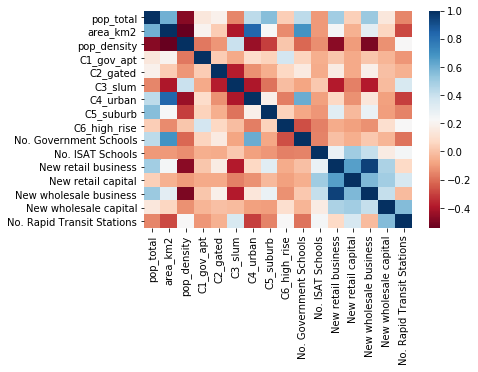

In [39]:
display(df.corr())
sns.heatmap(df.corr(), cmap = 'RdBu')


We see a high degree of correlation between number of new retail businesses and number of new wholesale businesses, with all others being relatively weak. Since using highly correlated features in cluster analysis is discouraged, we combine the number of business columns into a single one. 

In [40]:
df['No. New Businesses'] = df['New retail business'] + df['New wholesale business']
df.drop(['New retail business', 'New wholesale business'], axis = 1, inplace = True)
fixed_columns = list(df.columns[:-2]) +  [df.columns[-1]] + [df.columns[-2]]
df = df[fixed_columns]
df_prelim = df.copy()
df_prelim.head()

,District,pop_total,area_km2,pop_density,C1_gov_apt,C2_gated,C3_slum,C4_urban,C5_suburb,C6_high_rise,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,No. Rapid Transit Stations
0,Bang Bon,106919,34.745,3077.0,0,3,2,3,4,0,11,2.0,123.066666,155.683333,181.000000,0.0
1,Bang Kapi,146841,28.523,5148.0,0,11,8,1,9,0,14,6.0,550.151000,247.473333,278.333333,0.0
2,Bang Khae,193315,44.456,4348.0,0,12,23,6,8,0,15,1.0,253.000000,282.000000,275.000000,2.0
3,Bang Khen,191323,42.123,4542.0,1,20,7,2,36,11,6,0.0,210.953333,234.256667,294.000000,5.0
4,Bang Kho Laem,88288,10.921,8084.0,0,1,27,0,0,1,7,6.0,49.316667,154.966667,90.666667,0.0


It's not entirely clear what community type 1,2 and 6 add, as numbers are usually low. We will remove the asociated features. 

In [41]:
df_prelim.drop(['C1_gov_apt', 'C2_gated', 'C6_high_rise'], axis = 1, inplace = True)

In [42]:
df_prelim.describe()

,pop_total,area_km2,pop_density,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,No. Rapid Transit Stations
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,109346.040000,31.374640,6316.660000,13.160000,7.100000,8.52000,11.940000,3.500000,163.435345,333.261277,165.126667,2.300000
std,47761.066583,40.214508,4152.239718,12.179541,16.177901,13.87148,6.864312,5.218687,158.692747,522.558144,89.717139,2.991485
min,23655.000000,1.416000,732.000000,0.000000,0.000000,0.00000,2.000000,0.000000,28.517000,32.800000,33.000000,0.000000
25%,76342.000000,10.729000,4070.500000,3.000000,0.000000,0.25000,7.000000,1.000000,71.918792,92.610000,95.250000,0.000000
50%,103060.000000,19.027000,5293.500000,9.500000,0.000000,3.00000,10.000000,1.000000,103.953333,169.216667,138.166667,1.000000
75%,145878.250000,34.285750,8363.000000,18.000000,3.000000,9.75000,15.000000,6.000000,205.610000,296.325000,243.583333,4.000000
max,204532.000000,236.261000,23667.000000,47.000000,82.000000,73.00000,40.000000,25.000000,989.063047,3280.390000,382.666667,13.000000


### We normalize individual features with respect to area and population as appropriate.
* Aside from pop_total, area_km2 and pop_density, we will normalize all features with respect to either pop_total or area_km2
* Of these features we normalize all except No. Rapid Transit Stations with respect to pop_total (by district).
* We normalize No. Rapid Transit Stations with respect to area_km2 (by district).

,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,pop_density,No. Rapid Transit Stations
District,,,,,,,,,,
Bang Bon,0.000019,0.000028,0.000037,0.000103,0.000019,0.001151,0.001456,0.001693,3077.0,0.000000
Bang Kapi,0.000054,0.000007,0.000061,0.000095,0.000041,0.003747,0.001685,0.001895,5148.0,0.000000
Bang Khae,0.000119,0.000031,0.000041,0.000078,0.000005,0.001309,0.001459,0.001423,4348.0,0.044988
Bang Khen,0.000037,0.000010,0.000188,0.000031,0.000000,0.001103,0.001224,0.001537,4542.0,0.118700
Bang Kho Laem,0.000306,0.000000,0.000000,0.000079,0.000068,0.000559,0.001755,0.001027,8084.0,0.000000


,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,pop_density,No. Rapid Transit Stations
C3_slum,1.000000,-0.295206,-0.258276,0.078678,0.085189,-0.064786,-0.050861,-0.205801,0.479640,0.401114
C4_urban,-0.295206,1.000000,0.065692,0.334333,0.162237,-0.028810,-0.117576,0.225941,-0.433965,-0.296942
C5_suburb,-0.258276,0.065692,1.000000,-0.429756,-0.079999,-0.210546,-0.239537,-0.115186,-0.340907,-0.351100
No. Government Schools,0.078678,0.334333,-0.429756,1.000000,0.066345,0.352735,0.055014,0.242711,0.216006,0.143907
No. ISAT Schools,0.085189,0.162237,-0.079999,0.066345,1.000000,0.473447,0.260412,0.548776,-0.163912,0.099607
New retail capital,-0.064786,-0.028810,-0.210546,0.352735,0.473447,1.000000,0.666404,0.696727,0.087069,0.471279
New wholesale capital,-0.050861,-0.117576,-0.239537,0.055014,0.260412,0.666404,1.000000,0.622966,0.025962,0.520580
No. New Businesses,-0.205801,0.225941,-0.115186,0.242711,0.548776,0.696727,0.622966,1.000000,-0.155561,0.229668
pop_density,0.479640,-0.433965,-0.340907,0.216006,-0.163912,0.087069,0.025962,-0.155561,1.000000,0.467194
No. Rapid Transit Stations,0.401114,-0.296942,-0.351100,0.143907,0.099607,0.471279,0.520580,0.229668,0.467194,1.000000


,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,pop_density,No. Rapid Transit Stations
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.000144,0.000057,0.000063,0.000123,0.000040,0.001881,0.003551,0.001719,6316.660000,0.220267
std,0.000135,0.000136,0.000086,0.000074,0.000064,0.002197,0.004890,0.001227,4152.239718,0.310850
min,0.000000,0.000000,0.000000,0.000021,0.000000,0.000301,0.000343,0.000348,732.000000,0.000000
25%,0.000023,0.000000,0.000002,0.000079,0.000006,0.000654,0.000916,0.000971,4070.500000,0.000000
50%,0.000104,0.000000,0.000027,0.000100,0.000013,0.001141,0.001457,0.001539,5293.500000,0.028562
75%,0.000220,0.000029,0.000076,0.000149,0.000042,0.001751,0.003798,0.001750,8363.000000,0.386598
max,0.000485,0.000724,0.000431,0.000417,0.000292,0.011549,0.021039,0.005929,23667.000000,1.083815


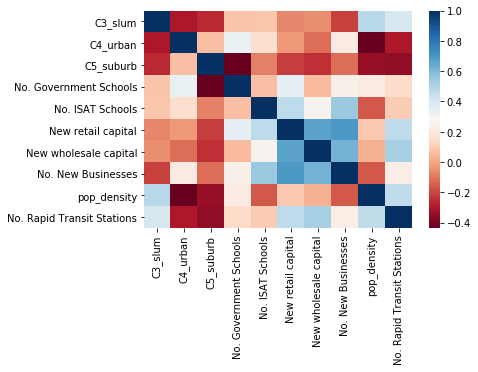

In [43]:
df = df_prelim.iloc[:,4:-1].div(df_prelim['pop_total'], axis=0)
df['pop_density'] = df_prelim['pop_density']
df['No. Rapid Transit Stations'] = df_prelim['No. Rapid Transit Stations']/df_prelim['area_km2']
df['District'] = df_prelim['District']
df.set_index('District', inplace = True)
display(df.head())
display(df.corr())
display(df.describe())
sns.heatmap(df.corr(), cmap = 'RdBu')


We must further normalize features so there values are on similar scales so we can hope to get meaningful results from most distance metrics. We use standard scaling as this is often recommended for PCA, which we will use later.

In [44]:
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(df)
columns = ['C3_slum', 'C4_urban', 'C5_suburb', 'No. Government Schools', 
           'No. ISAT Schools', 'New retail capital', 'New wholesale capital', 'No. New Businesses', 'pop_density', 'No. Rapid Transit Stations']
df_normed = pd.DataFrame(data = data, columns = columns)
df_normed['District'] = df_prelim['District']
df_normed.set_index('District', inplace = True)
df_normed.head()

,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,pop_density,No. Rapid Transit Stations
District,,,,,,,,,,
Bang Bon,-0.933945,-0.216710,-0.293909,-0.278285,-0.341019,-0.335762,-0.432782,-0.021786,-0.788141,-0.715789
Bang Kapi,-0.667180,-0.374285,-0.014748,-0.381766,0.009815,0.857446,-0.385429,0.145017,-0.284310,-0.715789
Bang Khae,-0.186248,-0.194619,-0.247477,-0.625326,-0.555320,-0.263257,-0.432230,-0.244342,-0.478934,-0.569593
Bang Khen,-0.800607,-0.347266,1.468459,-1.259806,-0.637236,-0.358023,-0.480642,-0.150388,-0.431737,-0.330057
Bang Kho Laem,1.206976,-0.424788,-0.731268,-0.602101,0.438942,-0.608114,-0.370985,-0.570045,0.429957,-0.715789


## 7. The meaningfulness of Euclidean distance in this context

Euclidean distance is known to behave poorly in high dimensions (part of the 'curse of dimensionality'). Roughly, the problem is that as dimension (number of features) increases, for each point the fraction $\frac{\text{distance to furthest point}}{\text{distance to nearest point}}$ tends to 1 for many data distribtuions.  Our data is 12-dimensionsal, so while problems are far from guaranteed, they are possible. For a preliminary test of whether we might reasonably expect Euclidean distance, and so K-means clustering, to be meaningful, we will test the fraction $\frac{\text{distance to furthest point}}{\text{distance to nearest point}}$ for each of the data points in our normed dataset.

In [45]:
euclid = metrics.pairwise.euclidean_distances(df_normed)
distances = pd.DataFrame(euclid)
display(distances.head())
minmax = []
for i in range(50):
    min_ = 100 
    max_ = -100
    for j in [*range(i), *range(i+1,50)]:
        min_ = min(distances.iloc[i,j], min_)
        max_ = max(distances.iloc[i,j], max_)
    minmax.append([min_,max_])

r = 0
for p in minmax:
    ratio = p[1]/p[0]
    #print(ratio)
    r += ratio
#print(minmax)    
average_ratio = r/50
average_ratio

        

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,1.419639,0.948592,2.118261,2.719129,1.540497,1.682111,3.735189,6.977143,3.708640,...,7.736061,2.320442,4.244768,2.341271,1.238855,4.308689,0.850463,1.719507,7.787514,1.572780
1,1.419639,0.000000,1.471549,2.269864,2.725927,2.260090,1.749327,3.753946,6.484678,3.719755,...,7.547293,2.145331,3.960150,2.933168,1.813143,4.260890,1.916662,1.579303,6.769912,1.732756
2,0.948592,1.471549,0.000000,1.958113,2.072056,1.888025,1.687508,3.011173,6.978626,2.934037,...,8.004413,2.077347,4.677181,2.560734,1.715676,3.745682,1.065728,1.469375,7.809585,1.503791
3,2.118261,2.269864,1.958113,0.000000,3.407040,2.913264,2.474080,4.150619,7.294659,3.954512,...,8.619976,2.496490,5.310006,3.717139,1.781984,4.884924,2.391360,2.532415,8.190284,3.022643
4,2.719129,2.725927,2.072056,3.407040,0.000000,3.290449,2.140926,2.031109,7.509442,2.017256,...,8.281340,2.362825,5.135832,3.387437,3.317366,2.747495,2.674578,1.938395,7.670316,1.680089


6.4584554235860505

We see that the average fraction $\frac{\text{distance to furthest point}}{\text{distance to nearest point}}$  is only 6.46. This is considered likely to produce unstable results from techniques suchas  K-means, so we should proceed with caution. <br>
<br>
We will try to visualize our data by preforming PCA down to 2 and 3 dimensions. <br>
<br>
First 2d:

Explained variance by component:  [0.31591521 0.23576645]
Total explained variance:  0.5516816645020237


<module 'matplotlib.pyplot' from 'C:\\Users\\Rob\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

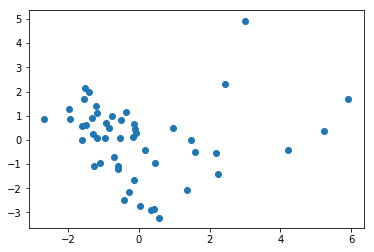

In [46]:
pca2 = decomposition.PCA(n_components = 2)
pca2.fit(df_normed)
print('Explained variance by component: ', pca2.explained_variance_ratio_)
print('Total explained variance: ', pca2.explained_variance_ratio_.sum())
data_2d = pca2.transform(df_normed)
#print(data_2d)
x, y = zip(*data_2d)

plt.scatter(x,y)
plt

This is not very promising. With 2 dimensions we only explain around 55% of the variance, and strong clusters do not appear. We will try now with 3d:

Explained variance by component:  [0.31591521 0.23576645 0.13970865]
Total explained variance:  0.6913903179110947


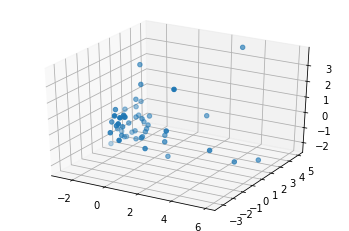

In [47]:
#%matplotlib notebook
pca3 = decomposition.PCA(n_components = 3)
pca3.fit(df_normed)
print('Explained variance by component: ', pca3.explained_variance_ratio_)
print('Total explained variance: ', pca3.explained_variance_ratio_.sum())
data_3d = pca3.transform(df_normed)

x1, x2, x3 = zip(*data_3d)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x1,x2,x3)


The move to 3 dimensions does not help much, if at all. There is no evidence of spherical clusters in the data, and there is no reason to believe that this will change if we increase the number of dimensions. So we should not expect K-means to produce meaningful results. <br>
<br>
There does seem to be some pattern to the data. There are areas of higher and lower density, and there appears to be a larger relatively dense cluster containing most of the data, and another smaller, sparser group. We will use the DBSCAN algorithm to try to get a better understanding of this.


## 8. Clustering with DBSCAN

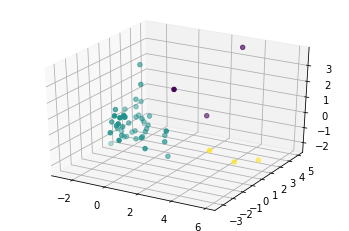

In [48]:
#%matplotlib notebook
dbscan = cluster.DBSCAN(eps = 2, min_samples = 3)
dbscan.fit(data_3d)
labels = dbscan.labels_

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x1,x2,x3,c = labels)


After playing around with the parameters min_samples and eps, we can get something that looks intuitively ok. Along with the large relatively dense cluster, we see a small loose cluster of 3 points in yellow, and some noise points in purple. This corresponds to what we can see in the 3D plot, but still, it is not a very useful clustering from the perspective of understanding districts in Bangkok. <br>

Total explained variance with  1 components:  0.31591521347333723
Total explained variance with  2 components:  0.5516816645020237
Total explained variance with  3 components:  0.6913903179110947
Total explained variance with  4 components:  0.7833043118328209
Total explained variance with  5 components:  0.8439758332329521
Total explained variance with  6 components:  0.8983842725390943
Total explained variance with  7 components:  0.932625049456993
Total explained variance with  8 components:  0.9633601858944203
Total explained variance with  9 components:  0.984035054509225
Total explained variance with  10 components:  0.9999999999999999


<module 'matplotlib.pyplot' from 'C:\\Users\\Rob\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

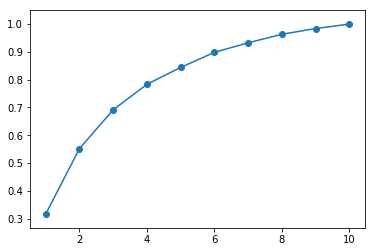

In [49]:
%matplotlib inline
nc = []
ev = []
for k in range(1,11):
    nc.append(k)
    pca = decomposition.PCA(n_components = k)
    pca.fit(df_normed)
    ev.append(pca.explained_variance_ratio_.sum())
    print('Total explained variance with ', k, 'components: ', pca.explained_variance_ratio_.sum())   

plt.scatter(nc,ev)
plt.plot(nc,ev)
plt


There is no obvious 'elbow' in the plot above, but we will use 2 dimensions anyway, as keeping the dimensionality low will likely improve the separation between the points.

In [50]:
pca = decomposition.PCA(n_components = 2)
pca.fit(df_normed)
print('Explained variance by component: ', pca.explained_variance_ratio_)
print('Total explained variance: ', pca.explained_variance_ratio_.sum())
print('Top two components: ', pca.components_)
data = pca.transform(df_normed)

Explained variance by component:  [0.31591521 0.23576645]
Total explained variance:  0.5516816645020237
Top two components:  [[ 0.09898914 -0.03344718 -0.27623516  0.24051131  0.28991493  0.48614833
   0.43590897  0.41519006  0.15277847  0.38574518]
 [-0.45350685  0.41796489  0.2339515   0.0013068   0.25066348  0.14148263
   0.08587195  0.33945686 -0.51590056 -0.30544068]]


We will use the canberra distance. This is a variation of 'manhattan' or 'taxicab' distance. The difference is that distance between features is weighted so that larger distances between larger features are effectively scaled down. This makes some intuitive sense here, as looking at the 3D plot above we see that the points are denser around the origin. The effect of the canberra weighting is that points closer to the origin must be closer together to share a cluster than points further away. So we can potentially capture meaningful clusters both in the dense area close to the origin, and in the sparse area further away. To use DBSCAN we must choose parameters eps and min_samples. The goal was to get a reasonably large number of clusters, while making the sizes of clusters as close as possible and minimizing the number of outliers (DBSCAN assigns outliers to cluster -1). 

In [51]:
dbscan = cluster.DBSCAN(eps = 0.8, min_samples = 4, metric = 'canberra')
dbscan.fit(data)
labels = np.array(dbscan.labels_)

print(labels)
num_groups = len(set(labels))
print('Number of clusters: ', max(1,num_groups -1 ))
for i in range(0,num_groups -1):
    count = labels.tolist().count(i)
    print('Size of cluster ', i, ' :', count)
print('Number of outliers: ', labels.tolist().count(-1))

# store the labels in a new variable for use later
labels_db = labels

[ 0  0  0  0  1  0  0  1 -1  1  1  2  0 -1  0  2  0  1 -1  0  0  2  2 -1
  0  0  0  0  0  2  1  1  0  2  2  0  1  2  0  2 -1 -1 -1  0  0 -1  0  0
 -1  0]
Number of clusters:  3
Size of cluster  0  : 24
Size of cluster  1  : 8
Size of cluster  2  : 9
Number of outliers:  9


 We can draw a picture using the 3D PCA projection calculated earlier. Remember that we are not using Euclidean distance so we cannot expect the clusters we have produced to make perfect sense accoring to our usual intuitions of space.

<module 'matplotlib.pyplot' from 'C:\\Users\\Rob\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

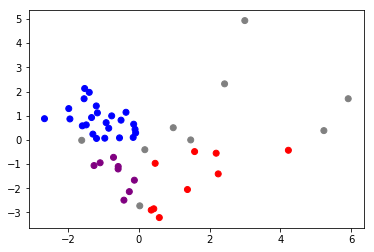

In [52]:
x, y = zip(*data)

# We will use this colour map and function to get consistent colours in our plots and graphs
colour_map = {-1 : 'gray', 0 : 'blue', 1 : 'purple', 2 : 'red'}

def get_colours(labels):
    colours = [colour_map.get(x) for x in labels]
    return colours
    

plt.scatter(x,y, c = get_colours(labels_db))
plt

In [53]:
# We can do a quick check to see that df_normed has districts in the same order as df_districts. 
# We want to use df_districts to draw a map of our clusters.
#display(df_districts.head())
#display(df_normed.head())

We can view our clusters on a map of Bangkok. Note that the clusters seem to capture some geographical information. In other words, they form a pattern on the map that looks like it should be meaningful.

In [54]:
lat = 13.8
long = 100.6
map_bangkok_clusters = folium.Map(location=[lat, long], zoom_start=10.5, control_scale = True)

for lat, lng, name, clust in zip(df_districts['Latitude'], df_districts['Longitude'], df_districts['District'], labels_db.tolist()):
    label = 'District: {}, Cluster: {}'.format(name,clust)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color = colour_map.get(clust),
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangkok_clusters) 
    
map_bangkok_clusters

### Investigating the clusters<br>
We will look at the results in our various categories of interest for each of the 3 clusters (+ outliers). We will obtain a dataframe with our features normalized by dividing by pop_total or area_km2 as before. We will also multiply features divided by pop_total by 100000 and the one divided by area_km2 by 10. This is to give us more human readable numbers.

In [55]:
df = 100000*df_prelim.iloc[:,4:-1].div(df_prelim['pop_total'], axis=0)
df['No. Rapid Transit Stations'] = 10*df_prelim['No. Rapid Transit Stations']/df_prelim['area_km2']
df['District'] = df_prelim['District']
df.set_index('District', inplace = True)
df['Cluster'] = labels
df['pop_total'] = df_districts['pop_total'].values
df['area_km2'] = df_districts['area_km2'].values
fixed_columns = list(df.columns[-3:]) + list(df.columns[:-3])
df_clust = df[fixed_columns]
display(df_clust.head())

,Cluster,pop_total,area_km2,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,No. Rapid Transit Stations
District,,,,,,,,,,,,
Bang Bon,0,106919,34.745,1.870575,2.805862,3.741150,10.288162,1.870575,115.102710,145.608669,169.287030,0.000000
Bang Kapi,0,146841,28.523,5.448070,0.681009,6.129078,9.534122,4.086052,374.657623,168.531496,189.547424,0.000000
Bang Khae,0,193315,44.456,11.897680,3.103743,4.138323,7.759356,0.517290,130.874479,145.875902,142.254869,0.449883
Bang Khen,0,191323,42.123,3.658734,1.045353,18.816347,3.136058,0.000000,110.260310,122.440411,153.666836,1.187000
Bang Kho Laem,1,88288,10.921,30.581733,0.000000,0.000000,7.928597,6.795941,55.858856,175.524043,102.694213,0.000000


Since we are interested in characterzing 'typical' members of each cluster, the median is probably the most meaningful measure of cluster center <sup>1</sup>, but we include mean and min/max for reference. Remember that cluster -1 is for outliers, so we should not expect any 'cluster center' measure to give us meaningful information in this case. Remember also that all features other than 'No. Rapid Transit Stations' and 'pop_total' and 'area_km2' are given per person/100000, and 'No. Rapid Transit Stations' is given per $km^2$/10. <br>
<br>
<sup>1</sup> Though with non-spherical clusters, cluster center is itself not necessarily informative.

In [56]:

display(df_clust.groupby('Cluster').median())
print('medians')

display(df_clust.groupby('Cluster').mean())
print('means')

display(df_clust.groupby('Cluster').max())
print('max')

display(df_clust.groupby('Cluster').min())
print('min')


,pop_total,area_km2,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,No. Rapid Transit Stations
Cluster,,,,,,,,,,,
-1,81689.0,15.0330,13.788824,0.000000,3.447206,11.676514,7.608420,261.108187,751.642538,303.998498,3.508362
0,144915.5,35.2850,2.662952,2.869694,6.821982,9.204209,1.596777,111.724745,143.439618,156.416284,0.000000
1,93066.0,11.4525,30.223404,0.000000,1.548383,12.010719,0.979955,54.130469,79.454866,79.327635,2.239057
2,67211.0,6.1800,22.650503,0.000000,0.000000,18.601959,1.385598,191.243080,174.584072,157.475466,6.926274


medians


,pop_total,area_km2,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,No. Rapid Transit Stations
Cluster,,,,,,,,,,,
-1,82031.777778,17.618000,15.931767,8.220989,4.120536,14.507483,9.287894,373.213404,916.262534,322.669153,3.310840
0,140999.000000,52.190500,6.468880,8.784564,10.820606,9.507141,2.967039,115.996623,188.744599,150.003758,0.255446
1,98533.000000,12.455125,26.645858,0.198443,1.544755,12.499188,1.508353,55.291245,126.181811,76.009088,2.062641
2,61864.000000,6.439667,23.107092,0.000000,0.402673,17.451742,3.815197,313.536822,441.105299,164.941960,6.411573


means


,pop_total,area_km2,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,No. Rapid Transit Stations
Cluster,,,,,,,,,,,
-1,155923,32.908,40.833751,72.391327,13.387265,31.024854,29.191285,1154.880837,2103.852543,592.919439,10.838150
0,204532,236.261,36.710180,47.401584,43.129169,23.122724,13.215665,374.657623,805.594214,244.699427,1.596679
1,125981,17.834,44.917724,1.587541,3.175082,20.830126,6.795941,97.046294,420.777598,102.694213,4.330879
2,101543,12.994,48.495933,0.000000,2.639254,41.681553,24.620112,790.210891,1547.145633,287.985890,9.823183


max


,pop_total,area_km2,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,No. Rapid Transit Stations
Cluster,,,,,,,,,,,
-1,29009,5.536,4.289544,0.0,0.0,6.413422,0.0,65.326665,34.291070,61.250626,0.0
0,68101,13.986,0.000000,0.0,0.0,2.057888,0.0,38.325915,53.529106,64.936316,0.0
1,70341,9.590,9.488266,0.0,0.0,5.686584,0.0,30.064099,34.579459,34.790309,0.0
2,23655,1.416,0.000000,0.0,0.0,7.878436,0.0,67.939673,57.654253,61.993820,0.0


min


We will get a better idea of what is going in with our clusters if we look at the distributions of the features within them. We will do this here by drawing box plots. Remember that one of the selling points of DBSCAN is that it is capable of finding clusters with irregular shapes, so we should not expect our clusters to be easily interpretable just by looking at the values they take for various features. Nevertheless, in our case the clusters are roughly blob shaped, so we can do this to some extent. Remember also that the 'noise' cluster is made up of those points that do not fit into another cluster, so we should not expect any internal unity for these points.

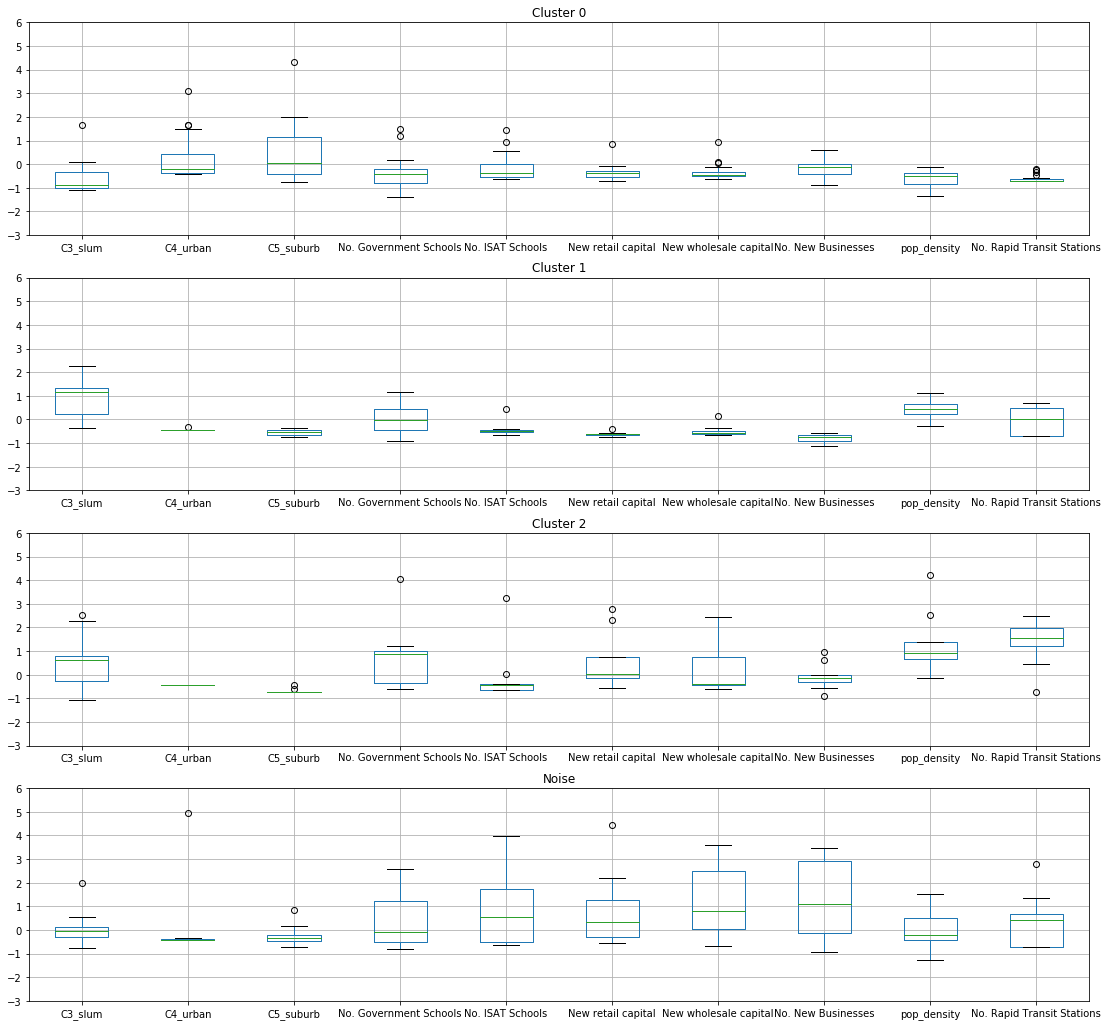

In [57]:
mask0 = df_clust['Cluster'] == 0
mask1 = df_clust['Cluster'] == 1
mask2 = df_clust['Cluster'] == 2
maskN = df_clust['Cluster'] == -1

columns = list(df_normed.columns)
fig, (ax0, ax1, ax2, axN) = plt.subplots(figsize=(19,18),nrows=4)
axes = [ax0, ax1, ax2, axN]
for i in range(len(axes)):
    axes[i].set_ylim(-3, 6)
    axes[i].set_title('Cluster ' + str(i))
    if i == 3:
        axes[i].set_title('Noise')
df_normed[mask0].boxplot(column = columns, ax = ax0, return_type = 'axes')
df_normed[mask1].boxplot(column = columns, ax = ax1, return_type = 'axes')
df_normed[mask2].boxplot(column = columns, ax = ax2, return_type = 'axes')
df_normed[maskN].boxplot(column = columns, ax = axN, return_type = 'axes')

### Cluster analysis: <br>
We will try and extract some information from the box plots. When a box plots displays little variation, it indicates that the districts in that cluster have values in a feature very close to each other.
* Cluster 0 (relatively suburban): Members of this cluster seem to be characterized by a low number of rapid transit links, and generally average or a little below average business investment. In addition there is below average population density. This indicates districts which are removed from the city center, and this is reflected in the geographical map above.
* Cluster 1 (urban relatively poor): This cluster is characterized by high population density, and a high proportion of the population living in slums as opposed to urban or suburban community types.
* Cluster 2 (urban relatively affluent): This cluster is similar to Cluster 1, but is distinghuished by relatively high capital investment, and better rapid transport links.
* Noise: As expected, for all features the 'Noise' category displays a high degree of variance, either in terms of wide box plots or with the presence of fairly extreme outliers. The 'cluster' seems to contain those districts which have an unusually high value for some feature. For example, unusually high investment, or a high number of ISAT schools. <br>  
<br>
We will use the Silhoutte score to measure how much the clusters are differentiated from each other. For this we first omit noise, as we should not expect noise points to have high within cluster similarity.

In [58]:
mask = labels == -1
not_noise = [x for x in labels if x != -1]
df = df_normed[~mask]
print('Silhoutte score: ', metrics.silhouette_score(df, not_noise, metric = 'canberra'))

Silhoutte score:  0.13733144825214982


The Silhoutte score is positive but close to zero, indicating poor differentiation between clusters. This is possibly to be expected given the sensitivity to the eps paramter in the application of the DBSCAN algorithm.

## 9. Agglomerative clustering

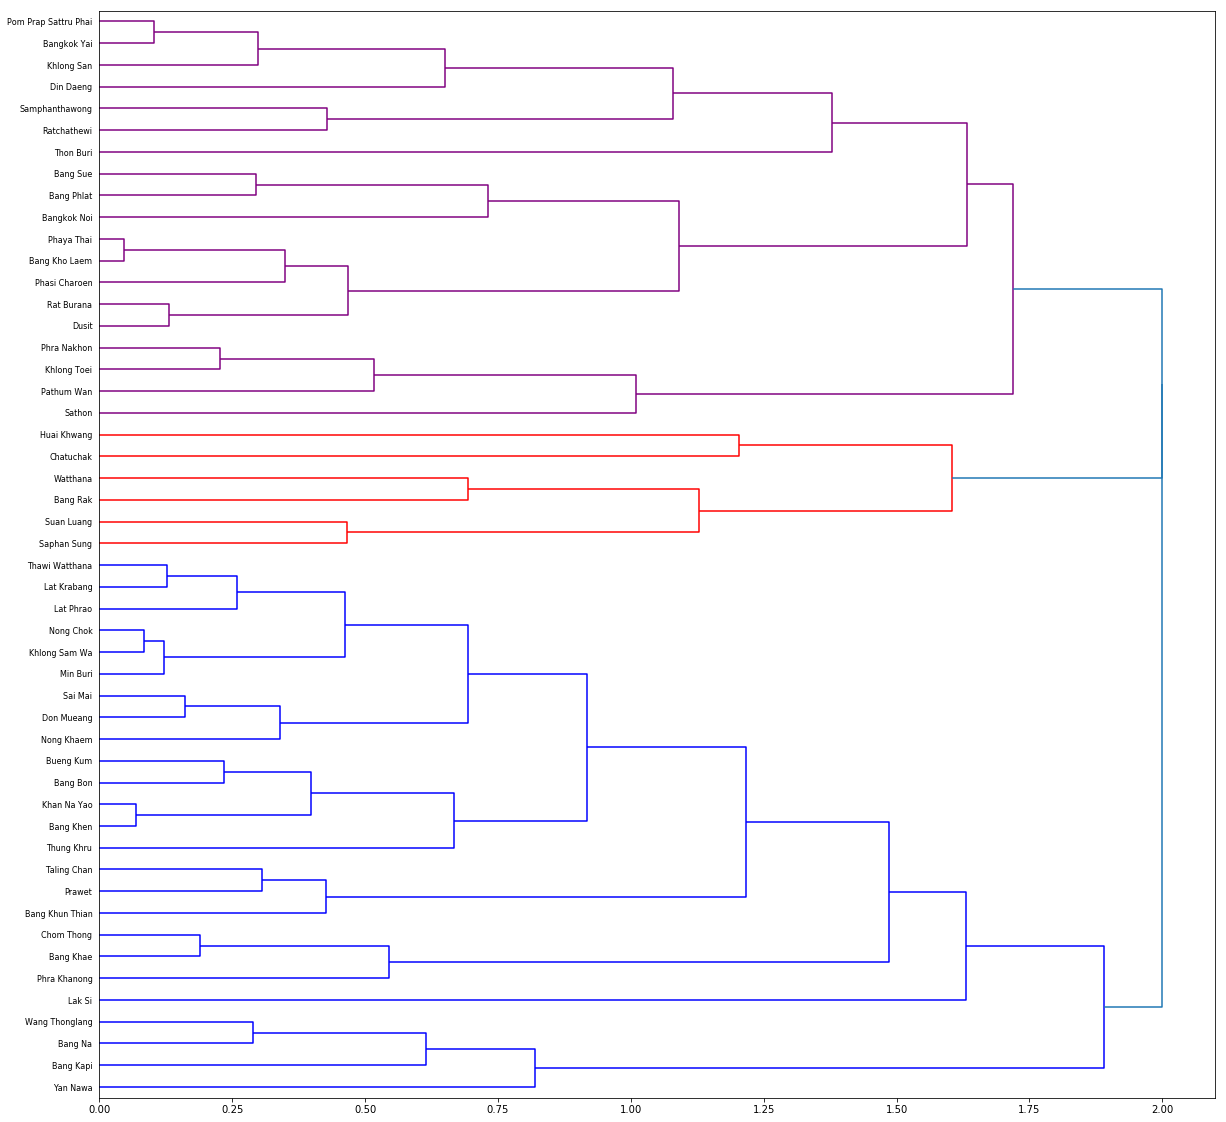

In [59]:
Z = hierarchy.linkage(data, method='complete', metric='canberra')

hierarchy.set_link_color_palette(['blue', 'red', 'purple'])
names = df_districts['District'].values
fig, ax = plt.subplots(figsize=(20,20))
R = hierarchy.dendrogram(Z, color_threshold = 2, orientation='right', labels=names, truncate_mode= None, ax = ax)


In [60]:
labels = hierarchy.fcluster(Z, 3, criterion = 'maxclust') 
labels = [x - 1 for x in labels]
print(labels)
# store labels in a new variable for later
labels_agg = labels

[0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 2, 2, 0, 1, 0, 2, 0, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 1, 0]


It will be conveinet later if we switch the labels 1 and 2 here.

In [61]:
def swap(x):
    if x == 1:
        return(2)
    elif x == 2:
        return(1)
    else:
        return(x)
    
labels_agg = [swap(x) for x in labels_agg] 

In [62]:
df = df_districts.copy()
df.set_index('District', inplace = True)
df['Cluster'] = labels_agg
fixed_columns = list(df.columns[-1:]) + list(df.columns[:-1])
df = df[fixed_columns]
display(df.head())
df_count = df[['Cluster', 'pop_total']]
df_count.columns = ['Cluster', 'Count']
display(df_count.groupby('Cluster').count())
df_agg = df

,Cluster,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude,C1_gov_apt,...,C4_urban,C5_suburb,C6_high_rise,No. Government Schools,No. ISAT Schools,New retail business,New retail capital,New wholesale business,New wholesale capital,No. Rapid Transit Stations
District,,,,,,,,,,,,,,,,,,,,,
Bang Bon,0,106919,34.745,3077.0,50,10150,4,13.659200,100.399100,0,...,3,4,0,11,2.0,78.666667,123.066666,102.333333,155.683333,0.0
Bang Kapi,0,146841,28.523,5148.0,6,10240,2,13.765833,100.647778,0,...,1,9,0,14,6.0,133.000000,550.151000,145.333333,247.473333,0.0
Bang Khae,0,193315,44.456,4348.0,40,10160,4,13.696111,100.409444,0,...,6,8,0,15,1.0,122.000000,253.000000,153.000000,282.000000,2.0
Bang Khen,0,191323,42.123,4542.0,5,10220,2,13.873889,100.596389,1,...,2,36,11,6,0.0,130.666667,210.953333,163.333333,234.256667,5.0
Bang Kho Laem,1,88288,10.921,8084.0,31,10120,3,13.693333,100.502500,0,...,0,0,1,7,6.0,34.666667,49.316667,56.000000,154.966667,0.0


,Count
Cluster,
0,25
1,19
2,6


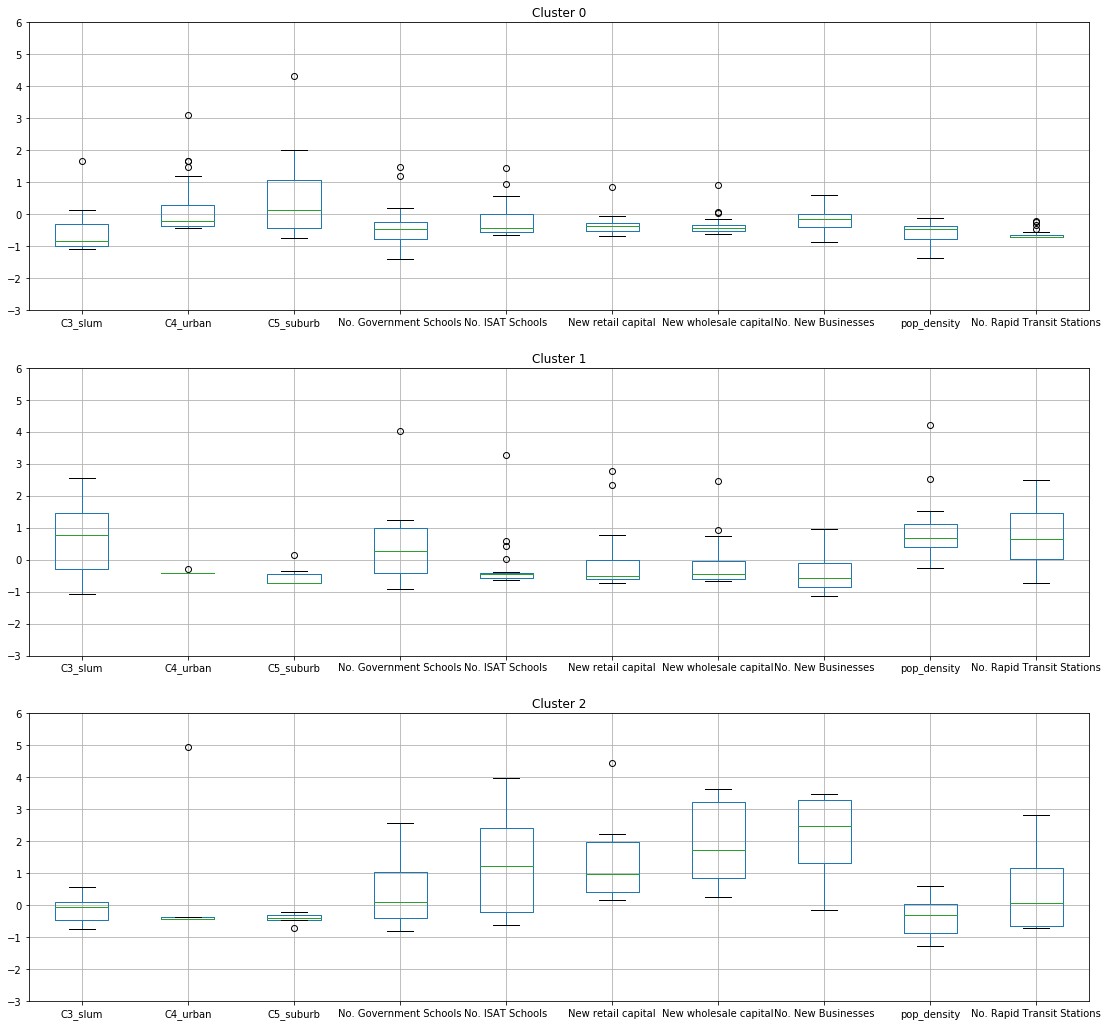

In [63]:
mask0 = df_agg['Cluster'] == 0
mask1 = df_agg['Cluster'] == 1
mask2 = df_agg['Cluster'] == 2

columns = list(df_normed.columns)
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(19,18),nrows=3)
axes = [ax0, ax1, ax2]
for i in range(len(axes)):
    axes[i].set_ylim(-3, 6)
    axes[i].set_title('Cluster ' + str(i))
    
df_normed[mask0].boxplot(column = columns, ax = ax0, return_type = 'axes')
df_normed[mask1].boxplot(column = columns, ax = ax1, return_type = 'axes')
df_normed[mask2].boxplot(column = columns, ax = ax2, return_type = 'axes')


Clusters here are similar to those produced by DBSCAN (this is why we switched labels 1 and 2 earlier). Now the distinction between Cluster 1 and Cluster 2 is clearer. It is interesting to note that Cluster 2 displays a high degree of variance, despite only having 6 members here.

<module 'matplotlib.pyplot' from 'C:\\Users\\Rob\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

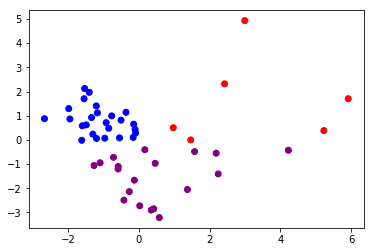

In [64]:
x, y = zip(*data)

plt.scatter(x,y, c = get_colours(labels_agg))
plt

In [65]:
lat = 13.8
long = 100.6
map_bangkok_clusters_2 = folium.Map(location=[lat, long], zoom_start=10.5, control_scale = True)

# draw map
for lat, lng, name, clust in zip(df_districts['Latitude'], df_districts['Longitude'], df_districts['District'], labels_agg):
    label = 'District: {}, Cluster: {}'.format(name,clust)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colour_map.get(clust),
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangkok_clusters_2) 
    
map_bangkok_clusters_2

## 10. Clustering with with K-Medoids

In [66]:
df = df_prelim.iloc[:,3:]
df['District'] = df_prelim['District']
df.set_index('District', inplace = True)
df = df.rank(ascending = False)
df.head()

,pop_density,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,No. Rapid Transit Stations
District,,,,,,,,,,
Bang Bon,42.0,42.0,14.5,21.0,20.5,20.5,23.0,27.0,17.0,39.0
Bang Kapi,27.0,29.5,21.5,14.0,15.0,12.5,2.0,18.0,7.0,39.0
Bang Khae,37.0,10.5,10.5,15.0,13.0,31.0,7.0,17.0,8.0,21.0
Bang Khen,35.0,32.0,17.5,3.0,45.5,45.0,12.0,19.0,5.0,9.0
Bang Kho Laem,14.0,7.0,37.5,44.0,40.0,12.5,47.0,28.0,38.0,39.0


In [67]:
#%matplotlib notebook
pca = decomposition.PCA(n_components = 2)
pca.fit(df)
print('Explained variance by component: ', pca.explained_variance_ratio_)
print('Total explained variance: ', pca.explained_variance_ratio_.sum())
data = pca.transform(df)


Explained variance by component:  [0.3867739  0.22589667]
Total explained variance:  0.6126705686779048


[0 0 0 0 1 0 2 1 2 1 1 1 0 2 0 2 0 1 2 0 0 1 2 0 0 0 0 0 0 2 1 1 2 1 1 2 1
 2 0 1 0 2 2 0 0 1 0 2 2 2]
Silhouette score:  0.4647096072231411


,Count
Cluster,
0,21
1,14
2,15


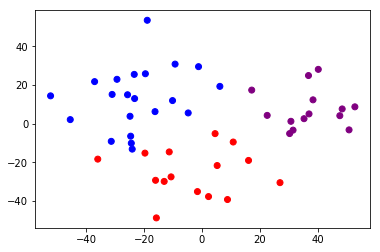

In [68]:
score = 0
optimal_labels = 0

for k in range(1000):
    kmed = cluster_ex.KMedoids(init = 'k-medoids++', n_clusters = 3, metric = 'manhattan', random_state = k)
    kmed.fit(data)
    labels = kmed.labels_
    s = metrics.silhouette_score(data, labels, metric = 'manhattan')
    if s > score:
        score = s
        optimal_labels = labels
        
labels = optimal_labels
print(labels)

# store labels as a new variable for use later
labels_med = labels

print('Silhouette score: ', metrics.silhouette_score(data, labels, metric = 'manhattan'))
    
x, y = zip(*data)

plt.scatter(x,y, c = get_colours(labels_med))
plt

df['Cluster'] = labels
df_count = df[['Cluster', 'pop_density']]
df_count.columns = ['Cluster', 'Count']
display(df_count.groupby('Cluster').count())


In [69]:
lat = 13.8
long = 100.6
map_bangkok_clusters_3 = folium.Map(location=[lat, long], zoom_start=10.5, control_scale = True)

colours = ['purple','blue','yellow']

for lat, lng, name, clust in zip(df_districts['Latitude'], df_districts['Longitude'], df_districts['District'], labels_med.tolist()):
    label = 'District: {}, Cluster: {}'.format(name,clust)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colour_map.get(clust),
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangkok_clusters_3) 
    
map_bangkok_clusters_3

In [70]:
df['Cluster'] = labels
fixed_columns = list(df.columns[-1:]) + list(df.columns[:-1])
df = df[fixed_columns]
df_med = df.copy()
df_med.head()

,Cluster,pop_density,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,No. Rapid Transit Stations
District,,,,,,,,,,,
Bang Bon,0,42.0,42.0,14.5,21.0,20.5,20.5,23.0,27.0,17.0,39.0
Bang Kapi,0,27.0,29.5,21.5,14.0,15.0,12.5,2.0,18.0,7.0,39.0
Bang Khae,0,37.0,10.5,10.5,15.0,13.0,31.0,7.0,17.0,8.0,21.0
Bang Khen,0,35.0,32.0,17.5,3.0,45.5,45.0,12.0,19.0,5.0,9.0
Bang Kho Laem,1,14.0,7.0,37.5,44.0,40.0,12.5,47.0,28.0,38.0,39.0


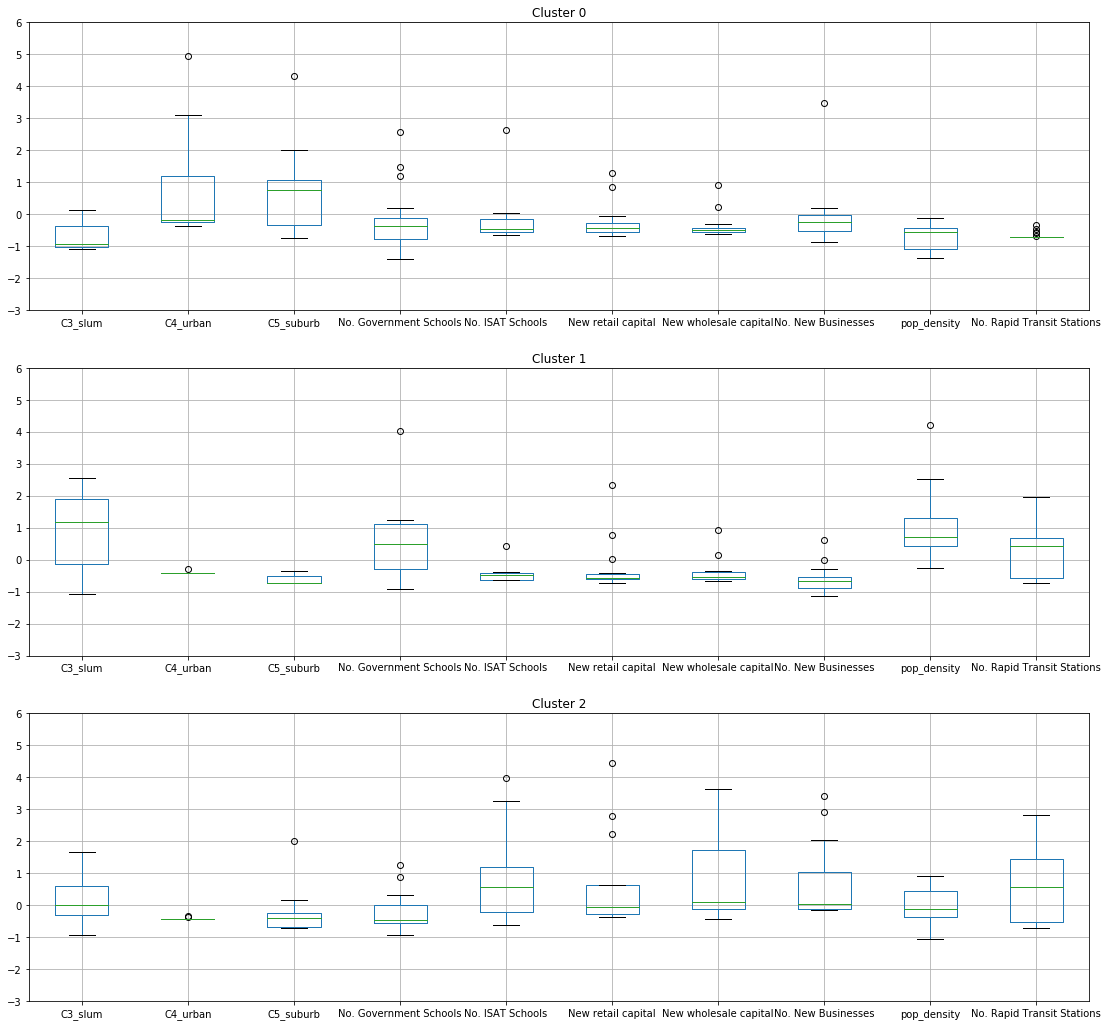

In [71]:
mask0 = df['Cluster'] == 0
mask1 = df['Cluster'] == 1
mask2 = df['Cluster'] == 2

columns = list(df_normed.columns)
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(19,18),nrows=3)
axes = [ax0, ax1, ax2]
for i in range(len(axes)):
    axes[i].set_ylim(-3, 6)
    axes[i].set_title('Cluster ' + str(i))
    
df_normed[mask0].boxplot(column = columns, ax = ax0, return_type = 'axes')
df_normed[mask1].boxplot(column = columns, ax = ax1, return_type = 'axes')
df_normed[mask2].boxplot(column = columns, ax = ax2, return_type = 'axes')

The clustering produced here similar to those produced by DBSCAN and Agglomerative Clustering (after the label switch). In other words, Cluster 0 is for less densely populated regions with poor rapid transit links, Cluster 1 is for dense, poor areas, and Cluster 2 districts of intermediate density with good rapid transit links and relatively high investment.

## 11. Comparison of clusterings <br>
<br>
We will use (adjusted) Rand scores to compare the clusterings we have obtained. I'm not sure what probability model sklearn uses to calculate the adjusted Rand score, so the internal calculation of the expected Rand score (roughly, the amount of agreement) may not be perfect for our situation. The numbers should not be taken too literally, but should still provide some useful information.

In [72]:
print('Rand score for Agglomerative Clustering and K-Medoids: ',metrics.rand_score(labels_agg,labels_med))
print('Adjusted Rand score for Agglomerative Clustering and K-Medoids: ',metrics.adjusted_rand_score(labels_agg, labels_med))
print()

# To compare the results from agglomerative clustering and K-medoids with the DBSCAN results we will first remove the noise.
no_noise_db = [x for x in labels_db if x != -1]
#print(no_noise_db)
no_noise_agg = []
for i in range(len(labels_db)):
    if labels_db[i] != -1:
        no_noise_agg.append(labels_agg[i])
#print(no_noise_agg) 

no_noise_med = []
for i in range(len(labels_db)):
    if labels_db[i] != -1:
        no_noise_med.append(labels_med[i])
#print(no_noise_med)


# Now we can compare the clusterings we get after removing districts marked as noise by DBSCAN.
print('Rand score for DBSCAN and Agglomerative Clustering: ', metrics.rand_score(no_noise_db, no_noise_agg))
print('Adjusted Rand score for DBSCAN and Agglomerative Clustering: ', metrics.adjusted_rand_score(no_noise_db, no_noise_agg))
print()


print('Rand score for DBSCAN and K-Medoids: ',metrics.rand_score(no_noise_db, no_noise_med))
print('Adjusted Rand score for DBSCAN and K-Medoids: ',metrics.adjusted_rand_score(no_noise_db, no_noise_med))
print()

print('Rand score for Agglomerative Clustering and K-Medoids with no noise: ',metrics.rand_score(no_noise_agg, no_noise_med))
print('Adjusted Rand score for Agglomerative Clustering and K-Medoids with no noise: ',metrics.adjusted_rand_score(no_noise_agg, no_noise_med))

Rand score for Agglomerative Clustering and K-Medoids:  0.7795918367346939
Adjusted Rand score for Agglomerative Clustering and K-Medoids:  0.5261922907223938

Rand score for DBSCAN and Agglomerative Clustering:  0.9121951219512195
Adjusted Rand score for DBSCAN and Agglomerative Clustering:  0.8245363766048502

Rand score for DBSCAN and K-Medoids:  0.7865853658536586
Adjusted Rand score for DBSCAN and K-Medoids:  0.5497332914967054

Rand score for Agglomerative Clustering and K-Medoids with no noise:  0.7963414634146342
Adjusted Rand score for Agglomerative Clustering and K-Medoids with no noise:  0.5932877932877932


The tests above show fairly high agreement for DBSCAN and Agglomerative clustering (after noise removal), which is not surprising as the data configuration and the metric used are the same. Agreement with K-medoids (after noise removal) is weaker, but still significantly better than would be expected from random assignments. Agreement between agglomerative clustering and K-medoids is weaker again, but still significant. Agreement between these two is slightly stronger if we remove noise.

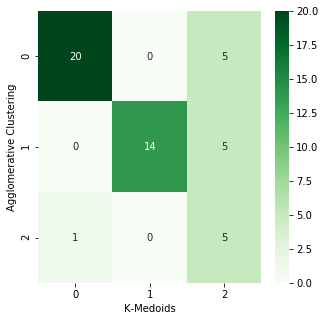

In [73]:
cm = metrics.confusion_matrix(labels_agg, labels_med, labels= [0,1,2], sample_weight=None, normalize=None)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap = plt.cm.Greens, ax = ax)
ax.set(xlabel="K-Medoids", ylabel = "Agglomerative Clustering")
plt.show()

Note that there is never any confusion between clusters 0 and 1. In other words, if one method assigns a district to Cluster 0, the other never assigns it to Cluster 1 (or vice versa). So the difficult districts seem to be those borderline between 2 and 0, and between 2 and 1. <br>
<br>
For reference we will investigate the districts where the K-Medoids and Agglomerative Clustering methods agree about the clusters. Note that Cluster 2 only has 5 things in it. 

In [74]:
agreements = np.array(labels_agg) == np.array(labels_med)
df_unified = df_med[agreements]
df_unified

,Cluster,pop_density,C3_slum,C4_urban,C5_suburb,No. Government Schools,No. ISAT Schools,New retail capital,New wholesale capital,No. New Businesses,No. Rapid Transit Stations
District,,,,,,,,,,,
Bang Bon,0,42.0,42.0,14.5,21.0,20.5,20.5,23.0,27.0,17.0,39.0
Bang Kapi,0,27.0,29.5,21.5,14.0,15.0,12.5,2.0,18.0,7.0,39.0
Bang Khae,0,37.0,10.5,10.5,15.0,13.0,31.0,7.0,17.0,8.0,21.0
Bang Khen,0,35.0,32.0,17.5,3.0,45.5,45.0,12.0,19.0,5.0,9.0
Bang Kho Laem,1,14.0,7.0,37.5,44.0,40.0,12.5,47.0,28.0,38.0,39.0
Bang Khun Thian,0,47.0,38.5,8.0,24.5,6.5,20.5,13.0,2.0,4.0,39.0
Bang Phlat,1,15.0,3.0,37.5,29.5,16.5,31.0,44.0,41.0,40.0,13.5
Bang Rak,2,12.0,38.5,37.5,44.0,40.0,45.0,6.0,4.0,6.0,6.0
Bang Sue,1,6.0,1.0,37.5,35.0,18.5,45.0,46.0,40.0,41.0,9.0


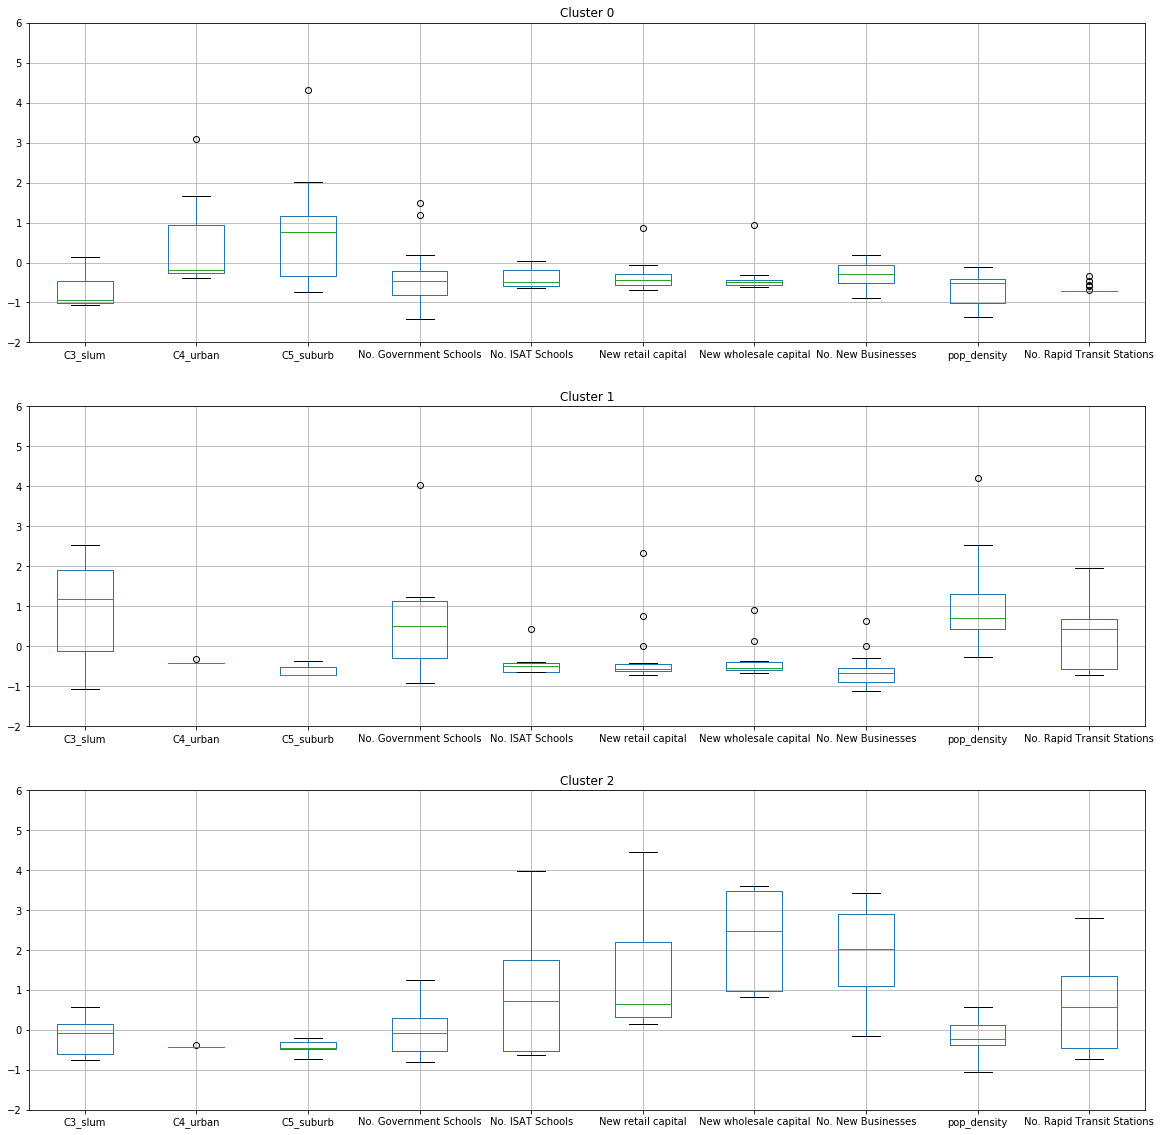

In [75]:
mask0 = df_unified['Cluster'] == 0
mask1 = df_unified['Cluster'] == 1
mask2 = df_unified['Cluster'] == 2

columns = list(df_normed.columns)
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(20,20),nrows=3)
axes = [ax0, ax1, ax2]
for i in range(len(axes)):
    axes[i].set_ylim(-2, 6)
    axes[i].set_title('Cluster ' + str(i))

df = df_normed[agreements]
df[mask0].boxplot(column = columns, ax = ax0, return_type = 'axes')
df[mask1].boxplot(column = columns, ax = ax1, return_type = 'axes')
df[mask2].boxplot(column = columns, ax = ax2, return_type = 'axes')

## 12. Foursquare venue analysis

We will search for locations in distircts using Foursquare based on the district center coordinates. <br>
Since districts have diferent sizes, the search radii should be different. <br>
We make the simplifying assumption that districts are circular. As can be seen from the map, this is not a very sound assumption, but it shouldn't be too bad for most districts. <br>
We will calculate the appropriate radius using the area of a cricle formula $a = \pi r^2$, i.e. $r = \sqrt{\frac{a}{\pi}}$.

In [76]:
# Obtain district radius in metres
df_districts['radius_m'] = np.sqrt((df_districts['area_km2']*1000000)/np.pi).astype('int')
print(df_districts.dtypes)
m = 32
print(type(m))
df_districts.head()

District                       object
pop_total                       int64
area_km2                      float64
pop_density                   float64
MapNr                           int64
Postcode                        int64
Subdistricts                    int64
Latitude                      float64
Longitude                     float64
C1_gov_apt                      int64
C2_gated                        int64
C3_slum                         int64
C4_urban                        int64
C5_suburb                       int64
C6_high_rise                    int64
No. Government Schools          int32
No. ISAT Schools              float64
New retail business           float64
New retail capital            float64
New wholesale business        float64
New wholesale capital         float64
No. Rapid Transit Stations    float64
radius_m                        int32
dtype: object
<class 'int'>


,District,pop_total,area_km2,pop_density,MapNr,Postcode,Subdistricts,Latitude,Longitude,C1_gov_apt,...,C5_suburb,C6_high_rise,No. Government Schools,No. ISAT Schools,New retail business,New retail capital,New wholesale business,New wholesale capital,No. Rapid Transit Stations,radius_m
0,Bang Bon,106919,34.745,3077.0,50,10150,4,13.659200,100.399100,0,...,4,0,11,2.0,78.666667,123.066666,102.333333,155.683333,0.0,3325
1,Bang Kapi,146841,28.523,5148.0,6,10240,2,13.765833,100.647778,0,...,9,0,14,6.0,133.000000,550.151000,145.333333,247.473333,0.0,3013
2,Bang Khae,193315,44.456,4348.0,40,10160,4,13.696111,100.409444,0,...,8,0,15,1.0,122.000000,253.000000,153.000000,282.000000,2.0,3761
3,Bang Khen,191323,42.123,4542.0,5,10220,2,13.873889,100.596389,1,...,36,11,6,0.0,130.666667,210.953333,163.333333,234.256667,5.0,3661
4,Bang Kho Laem,88288,10.921,8084.0,31,10120,3,13.693333,100.502500,0,...,0,1,7,6.0,34.666667,49.316667,56.000000,154.966667,0.0,1864


In [77]:
# Foursquare credentials
CLIENT_ID = '****'  
CLIENT_SECRET = '****' 
VERSION = '20180605' 

We search for venues in each of the 50 districts. This search is based on the district center coordinates, and the radius is calculated using the district radii calculated above. To get around the hard limit of 50 results per query we make separate queries for each of the categories 'food', 'drinks', 'coffee', 'shops', 'arts', 'outdoors', 'sights'. This will result in some duplication, but we will drop duplicates later. <br>
<br>
Since the below data retrieval takes a few minutes, I have changed the three cells immediately to markdown to avoid running them accidentally. The results of the initial retreival have been saved as a csv file, and this can be used to load the data in subsequent runs.

### Change cell types to code to run these
LIMIT = 50
places_jsons = []
sections = ['food', 'drinks', 'coffee', 'shops', 'arts', 'outdoors', 'sights']
for index, row in df_districts.iterrows():
    radius = int(row[['radius_m']])
    neighborhood_places = []
    neighborhood_latitude = row['Latitude']
    neighborhood_longitude = row['Longitude']
    category_jsons = []
    for section in sections:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, neighborhood_latitude, neighborhood_longitude, radius, LIMIT,section)
        category_jsons.append(requests.get(url).json())
    places_jsons.append(category_jsons)

places = []
for i in range(50):
    district = df_districts.loc[i,'District']
    neigh_lat = df_districts.loc[i,'Latitude']
    neigh_long = df_districts.loc[i,'Longitude']
    for k in range(len(places_jsons[i])):
        for place in places_jsons[i][k]["response"]['groups'][0]['items']:
            places.append([district, neigh_lat, neigh_long,
                          place['venue']['name'], 
                          place['venue']['location']['lat'], 
                          place['venue']['location']['lng'],  
                          place['venue']['categories'][0]['name']])
print(len(places))

columns = ['District', 'Area Latitude', 'Area Longitude', 'Venue Name', 
           'Venue Latitude', 'Venue Longitude', 'Venue Category']
df_places = pd.DataFrame(data = places, columns = columns)
pd.set_option('display.max_rows', None)
display(df_places.head(100))

df_places.to_csv('places.csv')

In [78]:
df_places = pd.read_csv('places.csv')
df_places.drop('Unnamed: 0', axis = 1, inplace = True)
df_places.head()

,District,Area Latitude,Area Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Bang Bon,13.6592,100.3991,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant
1,Bang Bon,13.6592,100.3991,ข้าวต้มม้วน,13.666550,100.412108,Asian Restaurant
2,Bang Bon,13.6592,100.3991,เจ๊ไน้ ก๋วยเตี๋ยวเป็ดตุ๋น,13.654137,100.405323,Noodle House
3,Bang Bon,13.6592,100.3991,KFC,13.670449,100.405502,Fast Food Restaurant
4,Bang Bon,13.6592,100.3991,Burger King (เบอร์เกอร์คิง),13.670830,100.405089,Fast Food Restaurant


Now drop duplicates. Note that some venues will be duplicated across districts due to our 'circular districts' assumption (some district circles will overlap each other). These will not be dropped, as the 'district' values will be different. What will be dropped here are venues that have been counted multiple within a district due to being in more than one category, e.g. 'food' and 'coffee'.

In [79]:
df_places = df_places.drop_duplicates()
df_places.shape

(11403, 7)

In [80]:
print('There are {} uniques categories.'.format(len(df_places['Venue Category'].unique())))
columns = ['Area Latitude', 'Area Longitude', 'Venue Name', 
           'Venue Latitude', 'Venue Longitude']
#display(df_places.head())
df_places = df_places.drop(columns, axis = 1)
pd.set_option('display.max_rows', None)
df_places.groupby('Venue Category').count()

There are 323 uniques categories.


,District
Venue Category,
Accessories Store,12
American Restaurant,3
Antique Shop,2
Arcade,2
Art Gallery,156
Art Museum,9
Arts & Crafts Store,10
Arts & Entertainment,18
Asian Restaurant,140


There are many redundancies in these cateogries, so we should unify some of them.

In [81]:
cats = {
'American Restaurant': 'Restaurant Western',
'Art Gallery' : 'Art Gallery/Museum',
'Art Museum' : 'Art Gallery/Museum',
'Asian Restaurant' : 'Restaurant Asian',
'Australian Restaurant': 'Restaurant Western',
'BBQ Joint': 'Restaurant Western',
'Badminton Court' : 'Sports Indoor',
'Baseball Field' : 'Sports Outdoor',
'Basketball Court' : 'Sports Outdoor',
'Beer Bar' : 'Bar',
'Beer Garden' : 'Bar',
'Bike Trail' : 'Sports Outdoor',
'Bistro' : 'Cafe',
'Boxing Gym' : 'Sports Indoor',
'Breakfast Spot' : 'Cafe',
'Brewery' : 'Bar',
'Bubble Tea Shop' : 'Cafe',
'Burger Joint' : 'Restaurant Western',
'Cafeteria' : 'Food Court',
'Café' : 'Cafe',
'Cajun / Creole Restaurant' : 'Restaurant Western',
'Cantonese Restaurant' : 'Restaurant Chinese', 
'Chinese Restaurant' : 'Restaurant Chinese',
'Cocktail Bar' : 'Bar',
'Coffee Roaster' : 'Cafe',
'Coffee Shop' : 'Cafe',
'Creperie' : 'Cafe',
'Cycle Studio' : 'Sports Indoor',
'Dance Studio' : 'Sports Indoor',
'Dessert Shop' : 'Cafe',
'Dim Sum Restaurant' : 'Restaurant Chinese',
'Diner' : 'Cafe',
'Dive Bar': 'Bar',
'Donburi Restaurant' : 'Restaurant Japanese',
'Dumpling Restaurant' : 'Restaurant Chinese',
'Eastern European Restaurant' : 'Restaurant Western',
'English Restaurant' : 'Restaurant Western',
'Exhibit' : 'Art Gallery/Museum',
'Fast Food Restaurant' : 'Restaurant Western',
'Fish & Chips Shop' : 'Restaurant Western',
'Food Service' : 'Food Court',
'French Restaurant' : 'Restaurant Western',
'Fried Chicken Joint' : 'Restaurant Western',
'Gastropub' : 'Bar',
'Gay Bar' : 'Bar',
'German Restaurant' : 'Restaurant Western',
'Golf Course' : 'Sports Outdoor',
'Golf Driving Range' : 'Sports Outdoor',
'Greek Restaurant' : 'Restaurant Mid Eastern',
'Gym / Fitness Center' : 'Gym',
'Gym Pool' : 'Sports Outdoor',
'Hainan Restaurant' : 'Restaurant Chinese',
'Halal Restaurant' : 'Restaurant Mid Eastern',	
'History Museum' : 'Museum',
'Hookah Bar' : 'Bar',
'Hotel Bar': 'Bar',
'Hotpot Restaurant' : 'Restaurant Asian',
'Indian Restaurant' : 'Restaurant Mid Eastern',
'Israeli Restaurant' : 'Restaurant Mid Eastern',
'Italian Restaurant' : 'Restaurant Western',
'Japanese Curry Restaurant' : 'Restaurant Japanese',
'Japanese Restaurant' : 'Restaurant Japanese',
'Jazz Club' : 'Bar',
'Kaiseki Restaurant' : 'Restaurant Japanese',
'Korean Restaurant' : 'Restaurant Asian',
'Martial Arts School' : 'Sports Indoor',
'Mediterranean Restaurant' : 'Restaurant Western',
'Mexican Restaurant' : 'Restaurant Western',
'Middle Eastern Restaurant' : 'Restaurant Mid Eastern',
'Modern European Restaurant' : 'Restaurant Western',
'New American Restaurant' : 'Restaurant Western',
'Nightclub' : 'Bar',
'Nightlife Spot' : 'Bar',
'Noodle House' : 'Restaurant Asian',
'Other Nightlife' : 'Bar',
'Outdoor Sculpture' : 'Art Gallery/Museum',
'Pet Café' : 'Cafe',
'Piano Bar' : 'Bar',
'Pilates Studio' : 'Sports Indoor',
'Pizza Place' : 'Restaurant Western',
'Pool' : 'Sports Outdoor',
'Pub' : 'Bar',
'Public Art' : 'Art Gallery/Museum',
'Ramen Restaurant' : 'Restaurant Japanese',
'Rock Climbing Spot' : 'Sports Indoor',
'Rock Club' : 'Bar',
'Roof Deck' : 'Bar',
'Rooftop Bar': 'Bar',
'Sake Bar' : 'Bar',
'Sandwich Place' : 'Cafe',
'Satay Restaurant' : 'Restaurant Asian',
'Science Museum' : 'Museum',
'Shabu-Shabu Restaurant' : 'Restaurant Asian',
'Shanghai Restaurant' : 'Restaurant Chicken',
'Skate Park' : 'Recreation',
'Skating Rink' : 'Recreation',
'Ski Area' : 'Sports Outdoor',
'Snack Place' : 'Cafe',
'Soba Restaurant' : 'Restaurant Japanese',
'Soccer Field' : 'Sports Outdoor',
'Som Tum Restaurant' : 'Restaurant Asian',
'Sports Bar' : 'Bar',
'Sports Club' : 'Sports Outdoor',
'Squash Court' : 'Sports Indoor',
'Steakhouse' : 'Restaurant Western',
'Street Food Gathering' : 'Restaurant Asian',
'Strip Club' : 'Bar',
'Sushi Restaurant' : 'Restaurant Japanese',
'Swiss Restaurant' : 'Restaurant Western',
'Takoyaki Place' : 'Restaurant Japanese',
'Tapas Restaurant' : 'Restaurant Western',
'Tea Room' : 'Cafe',
'Tennis Court' : 'Sports Outdoor',
'Thai Restaurant' : 'Restaurant Asian',
'Tonkatsu Restaurant' : 'Restaurant Japanese',
'Track' : 'Sports Outdoor',
'Udon Restaurant' : 'Restaurant Japanese',
'Vietnamese Restaurant' : 'Restaurant Asian',
'Volleyball Court' : 'Sports Indoor',
'Water Park' : 'Recreation',
'Weight Loss Center' : 'Gym',
'Whisky Bar' : 'Bar',
'Wine Bar': 'Bar',
'Wings Joint' : 'Restaurant Western',
'Yoga Studio' : 'Sports Indoor',
'Yoshoku Restaurant' : 'Restaurant Japanese',
'Bowling Alley' : 'Recreation',
'Comedy Club' : 'Performing Arts',
'Concert Hall' : 'Performing Arts',
'Escape Room' : 'Recreation',
'Gaming Cafe' : 'Recreation',
'Gun Range' : 'Recreation',
'Hot Spring' : 'Recreation',
'Indie Movie Theater' : 'Recreation',
'Indie Theater' : 'Performing Arts',
'Karaoke Bar' : 'Recreation',
'Laser Tag' : 'Recreation',
'Massage Studio' : 'Recreation',
'Mini Golf' : 'Recreation',
'Movie Theater' : 'Recreation',
'Multiplex' : 'Recreation',
'Music Venue' : 'Performing Arts',
'Opera House' : 'Performing Arts',
'Outdoors & Recreation' : 'Recreation',
'Paintball Field' : 'Recreation',
'Performing Arts Venue' : 'Performing Arts',
'Recreation Center' : 'Recreation',
'Roller Rink' : 'Recreation',
'Spa' : 'Recreation',
'Speakeasy' : 'Bar',
'Theater' : 'Performing Arts',
'Theme Park' : 'Recreation',
'Theme Park Ride / Attraction' : 'Recreation',
'Accessories Store' : 'Specialist Store',
'Antique Shop' : 'Specialist Store',
'Arts & Crafts Store' : 'Specialist Store',
'Big Box Store' : 'Large Store/Mall',
'Boutique' : 'Specialist Store',
'Bookstore' : 'Specialist Store',
'Bridal Shop' : 'Specialist Store',
'Camera Store' : 'Specialist Store',
'Campground' : 'Recreation',
'Comic Shop' : 'Specialist Store',
'Construction & Landscaping' : 'Specialist Store',
'Costume Shop' : 'Specialist Store',
'Cosmetics Shop' : 'Specialist Store',
'Department Store' : 'Large Store/Mall',
'Electronics Store' : 'Specialist Store',
'Fabric Shop' : 'Specialist Store',
'Farmers Market' : 'Market',
'Floating Market' : 'Market',
'Fishing Store' : 'Specialist Store',
'Dive Shop' : 'Specialist Store',
'Flower Shop' : 'Specialist Store',
'Gift Shop' : 'Specialist Store',
'Gourmet Shop' : 'Specialist Store',
'Health Food Store' : 'Specialist Store',
'Herbs & Spices Store' : 'Specialist Store',
'Hobby Shop' : 'Specialist Store',
'Jewelry Store' : 'Specialist Store',
'Kids Store' : 'Specialist Store',
'Leather Goods Store' : 'Specialist Store',
'Lingerie Store' : 'Specialist Store',
'Lounge' : 'Bar',
'Flea Market' : 'Market',
'Motorcycle Shop' : 'Specialist Shop',
'Music Store' : 'Specialist Shop',
'Night Market' : 'Market',
'Optical Shop' : 'Specialist Store',
'Paper / Office Supplies Store' : 'Specialist Store',
'Organic Grocery' : 'Specialist Store',
'Outlet Store' : 'Specialist Store',
'Perfume Shop' : 'Specialist Store',
'Pet Store' : 'Specialist Store',
'Pharmacy' : 'Specialist Store',
'Planetarium' : 'Recreation',
'Shoe Store' : 'Specialist Store',
'Shipping Store' : 'Specialist Store',
'Shopping Mall' : 'Large Store/Mall',
'Shopping Plaza' : 'Large Store/Mall',
'Souvenir Shop' : 'Specialist Store',
'Sporting Goods Shop' : 'Specialist Store',
'Stationery Store' : 'Specialist Store',
'Supermarket' : 'Large Store/Mall',
'Tailor Shop' : 'Specialist Store',
'Thrift / Vintage Store' : 'Specialist Store',
'Toy / Game Store' : 'Specialist Store',
'Video Store' : 'Specialist Store',
'Warehouse Store' : 'Large Store/Mall',
'Watch Shop' : 'Specialist Store',
'Wine Shop' : 'Specialist Store',
"Women's Store" : 'Specialist Store',
'Arcade' : 'Recreation',
'Bakery' : 'Desserts',
'Auto Garage' : 'Garage',
'Bike Shop' : 'Specialist Store',
'Chocolate Shop' : 'Desserts',
'Clothing Store' : 'Specialist Store',
'Donut Shop' : 'Desserts',
'Drugstore' : 'Specialist Store',
'Frozen Yogurt Shop' : 'Desserts',
'Furniture / Home Store' : 'Specialist Store',
'Ice Cream Shop' : 'Desserts',
'Mobile Phone Shop' : 'Specialist Store',
'Pastry Shop' : 'Desserts',
'Smoothie Shop' : 'Desserts',
}

In [82]:
df_places['Venue Category'] = df_places['Venue Category'].replace(to_replace = cats)
df_places.head()

,District,Venue Category
0,Bang Bon,Restaurant Asian
1,Bang Bon,Restaurant Asian
2,Bang Bon,Restaurant Asian
3,Bang Bon,Restaurant Western
4,Bang Bon,Restaurant Western


In [83]:
places_onehot = pd.get_dummies(df_places['Venue Category'])
places_onehot['District'] = df_places['District'] 
fixed_columns = [places_onehot.columns[-1]] + list(places_onehot.columns[:-1])
places_onehot = places_onehot[fixed_columns]
print(places_onehot.shape)
#pd.set_option('display.max_columns', None)
places_onehot.head()

(11403, 115)


,District,Art Gallery/Museum,Arts & Entertainment,Astrologer,Athletics & Sports,Bar,Bay,Beach,Botanical Garden,Buddhist Temple,...,Stables,Stadium,Tour Provider,Trail,Vegetarian / Vegan Restaurant,Vineyard,Waterfall,Waterfront,Zoo,Zoo Exhibit
0,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
places_counts = places_onehot.groupby('District').sum().reset_index()
places_counts.set_index('District', inplace = True)
print(places_counts.shape)
display(places_counts.head())

(50, 114)


,Art Gallery/Museum,Arts & Entertainment,Astrologer,Athletics & Sports,Bar,Bay,Beach,Botanical Garden,Buddhist Temple,Buffet,...,Stables,Stadium,Tour Provider,Trail,Vegetarian / Vegan Restaurant,Vineyard,Waterfall,Waterfront,Zoo,Zoo Exhibit
District,,,,,,,,,,,,,,,,,,,,,
Bang Bon,0,0,0,2,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Bang Kapi,4,1,0,1,31,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Bang Khae,1,0,0,0,12,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Bang Khen,1,1,0,0,10,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
Bang Kho Laem,2,0,0,0,25,0,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0


We still have a large number of venue types, many of which are redundant. To trim the number of features down to a manageable level, we will drop all venue tyes with fewer than 100 occurrences. We will also normalize using standard scaler.

In [85]:
df = places_counts.copy()
df = df[df.columns[df.sum(axis = 0) > 99 ]]
print(df.shape)

display(df.describe())

(50, 19)


,Art Gallery/Museum,Bar,Cafe,Convenience Store,Desserts,Gym,Large Store/Mall,Market,Museum,Park,Performing Arts,Recreation,Restaurant Asian,Restaurant Chinese,Restaurant Japanese,Restaurant Western,Specialist Store,Sports Indoor,Sports Outdoor
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000
mean,3.700000,20.660000,46.440000,18.200000,3.520000,11.680000,8.94000,7.280000,2.580000,3.140000,3.840000,6.880000,26.760000,2.480000,4.040000,7.300000,12.300000,6.620000,11.40000
std,4.500567,13.362466,6.887315,6.845228,1.961257,5.585842,3.78725,3.307629,4.721164,2.267877,3.919392,5.073501,5.385392,2.224538,3.350053,3.202359,6.925994,4.480752,4.30472
min,0.000000,1.000000,22.000000,2.000000,0.000000,2.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.00000
25%,1.000000,11.250000,46.000000,14.000000,2.000000,7.000000,6.00000,5.000000,0.000000,1.000000,1.000000,4.000000,24.000000,1.000000,2.000000,5.000000,7.250000,3.000000,9.00000
50%,2.000000,16.500000,48.000000,18.000000,3.500000,11.500000,8.00000,7.000000,1.000000,3.000000,2.500000,6.000000,26.500000,2.000000,3.000000,7.000000,11.000000,5.500000,11.00000
75%,6.000000,30.000000,50.000000,22.750000,5.000000,16.000000,11.75000,9.000000,2.000000,4.000000,5.000000,8.000000,30.000000,3.000000,5.000000,9.000000,15.750000,8.000000,14.00000
max,21.000000,47.000000,54.000000,31.000000,9.000000,22.000000,17.00000,17.000000,27.000000,12.000000,21.000000,29.000000,38.000000,12.000000,15.000000,15.000000,33.000000,18.000000,21.00000


We will normalize by dividing by district populations/100000.

In [86]:
# df = df.div(df_districts.values[:,1], axis = 0)*100000
df = df.div(df_districts.values[:,1], axis = 0)*100000
df = df.astype('float')
df.head()

,Art Gallery/Museum,Bar,Cafe,Convenience Store,Desserts,Gym,Large Store/Mall,Market,Museum,Park,Performing Arts,Recreation,Restaurant Asian,Restaurant Chinese,Restaurant Japanese,Restaurant Western,Specialist Store,Sports Indoor,Sports Outdoor
District,,,,,,,,,,,,,,,,,,,
Bang Bon,0.000000,5.611725,45.829086,20.576324,0.935287,10.288162,7.482300,8.417587,0.000000,3.741150,0.000000,6.547012,28.058624,2.805862,1.870575,8.417587,8.417587,8.417587,14.964599
Bang Kapi,2.724035,21.111270,32.688418,14.301183,3.405044,13.620174,7.491096,8.853113,1.362017,2.043026,6.129078,6.810087,19.749253,0.681009,4.767061,6.810087,6.810087,4.086052,7.491096
Bang Khae,0.517290,6.207485,23.795360,5.690195,2.586452,3.103743,8.793937,5.690195,0.000000,2.069162,1.034581,4.138323,12.414970,0.517290,3.103743,7.242066,5.172904,3.103743,3.103743
Bang Khen,0.522676,5.226763,26.133816,11.498879,2.090705,6.272116,6.794792,4.181410,1.045353,0.522676,2.090705,4.181410,16.725642,0.522676,2.090705,3.136058,3.136058,1.568029,10.976203
Bang Kho Laem,2.265314,28.316419,54.367524,18.122508,5.663284,16.989851,12.459224,6.795941,1.132657,2.265314,5.663284,6.795941,32.847046,7.928597,1.132657,3.397970,16.989851,7.928597,11.326568


In [87]:
display(df.corr())

,Art Gallery/Museum,Bar,Cafe,Convenience Store,Desserts,Gym,Large Store/Mall,Market,Museum,Park,Performing Arts,Recreation,Restaurant Asian,Restaurant Chinese,Restaurant Japanese,Restaurant Western,Specialist Store,Sports Indoor,Sports Outdoor
Art Gallery/Museum,1.000000,0.754832,0.626313,0.162402,0.468713,0.515248,0.748942,0.370645,0.553881,0.482597,0.367687,0.621173,0.508317,0.671513,0.435401,0.438859,0.690300,0.487314,0.280629
Bar,0.754832,1.000000,0.632507,0.227276,0.682076,0.607385,0.732007,0.260239,0.691908,0.623086,0.698294,0.762220,0.512292,0.327211,0.520783,0.469160,0.527636,0.614696,0.351299
Cafe,0.626313,0.632507,1.000000,0.679233,0.601248,0.760737,0.796593,0.648819,0.376655,0.588383,0.370052,0.619488,0.922374,0.652217,0.413765,0.700781,0.701925,0.585889,0.766594
Convenience Store,0.162402,0.227276,0.679233,1.000000,0.387059,0.567724,0.407343,0.393893,0.083376,0.293847,0.216979,0.121894,0.690819,0.305700,0.210350,0.594393,0.132676,0.391856,0.676099
Desserts,0.468713,0.682076,0.601248,0.387059,1.000000,0.537393,0.612514,0.240084,0.636654,0.465015,0.519945,0.647307,0.534913,0.167181,0.463979,0.577773,0.417802,0.378293,0.472475
Gym,0.515248,0.607385,0.760737,0.567724,0.537393,1.000000,0.809728,0.306157,0.128807,0.530888,0.423703,0.555301,0.553768,0.338763,0.585155,0.769949,0.334418,0.699064,0.581195
Large Store/Mall,0.748942,0.732007,0.796593,0.407343,0.612514,0.809728,1.000000,0.358939,0.334449,0.514974,0.548463,0.632837,0.599470,0.507615,0.599886,0.726505,0.488740,0.784793,0.664025
Market,0.370645,0.260239,0.648819,0.393893,0.240084,0.306157,0.358939,1.000000,0.268102,0.249645,-0.005387,0.199501,0.710065,0.655153,0.026287,0.303867,0.578861,0.241066,0.337343
Museum,0.553881,0.691908,0.376655,0.083376,0.636654,0.128807,0.334449,0.268102,1.000000,0.406007,0.439384,0.542736,0.425307,0.232810,0.126777,0.104897,0.452322,0.144752,0.096962
Park,0.482597,0.623086,0.588383,0.293847,0.465015,0.530888,0.514974,0.249645,0.406007,1.000000,0.355426,0.653271,0.517376,0.141806,0.236079,0.333234,0.362958,0.302100,0.485405


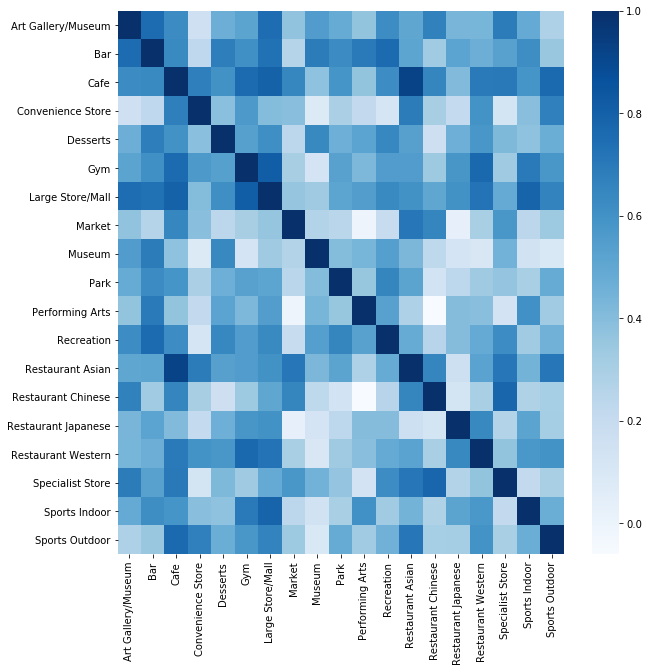

In [88]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df.corr(), cmap = plt.cm.Blues, ax = ax)

In [89]:
pd.set_option('display.max_columns', None)
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.RobustScaler()
#scaler = preprocessing.MinMaxScaler()
data = scaler.fit_transform(df)
df = pd.DataFrame(data = data, columns = df.columns)
df['District'] = df_districts['District']
fixed_columns = [df.columns[-1]] + list(df.columns[:-1])
df = df[fixed_columns]
df.set_index('District', inplace = True)
df_venues_trimmed = df.copy()
df_venues_trimmed.head()

,Art Gallery/Museum,Bar,Cafe,Convenience Store,Desserts,Gym,Large Store/Mall,Market,Museum,Park,Performing Arts,Recreation,Restaurant Asian,Restaurant Chinese,Restaurant Japanese,Restaurant Western,Specialist Store,Sports Indoor,Sports Outdoor
District,,,,,,,,,,,,,,,,,,,
Bang Bon,-0.580831,-0.867423,-0.242068,0.100946,-0.892991,-0.321342,-0.390679,0.328438,-0.451753,0.161734,-0.878462,-0.210556,-0.136397,-0.140241,-0.642551,0.099839,-0.421986,0.152804,0.324959
Bang Kapi,-0.291022,-0.175972,-0.666497,-0.453952,-0.205889,-0.014765,-0.389324,0.457625,-0.294303,-0.481260,0.329987,-0.180642,-0.618256,-0.517902,0.080064,-0.245842,-0.506379,-0.578097,-0.652736
Bang Khae,-0.525796,-0.840846,-0.953733,-1.215406,-0.433627,-0.982378,-0.188669,-0.480569,-0.451753,-0.471363,-0.674477,-0.484444,-1.043570,-0.547001,-0.334900,-0.152948,-0.592331,-0.743852,-1.226697
Bang Khen,-0.525223,-0.884597,-0.878204,-0.701755,-0.571547,-0.690857,-0.496564,-0.928108,-0.330910,-1.056939,-0.466245,-0.479545,-0.793595,-0.546044,-0.587633,-1.035915,-0.699265,-1.002988,-0.196809
Bang Kho Laem,-0.339825,0.145457,0.033714,-0.116040,0.422368,0.295277,0.375834,-0.152579,-0.320818,-0.397091,0.238148,-0.182250,0.141283,0.770251,-0.826646,-0.979592,0.028056,0.070292,-0.150974


### Venue profiles for K-Medoids district clusters <br>
We will use the clusters produced by K-Medoids, as this has a reasonable number of districts in each cluster.

In [90]:
df = df_venues_trimmed.copy()
print(df.shape)
df.head()

(50, 19)


,Art Gallery/Museum,Bar,Cafe,Convenience Store,Desserts,Gym,Large Store/Mall,Market,Museum,Park,Performing Arts,Recreation,Restaurant Asian,Restaurant Chinese,Restaurant Japanese,Restaurant Western,Specialist Store,Sports Indoor,Sports Outdoor
District,,,,,,,,,,,,,,,,,,,
Bang Bon,-0.580831,-0.867423,-0.242068,0.100946,-0.892991,-0.321342,-0.390679,0.328438,-0.451753,0.161734,-0.878462,-0.210556,-0.136397,-0.140241,-0.642551,0.099839,-0.421986,0.152804,0.324959
Bang Kapi,-0.291022,-0.175972,-0.666497,-0.453952,-0.205889,-0.014765,-0.389324,0.457625,-0.294303,-0.481260,0.329987,-0.180642,-0.618256,-0.517902,0.080064,-0.245842,-0.506379,-0.578097,-0.652736
Bang Khae,-0.525796,-0.840846,-0.953733,-1.215406,-0.433627,-0.982378,-0.188669,-0.480569,-0.451753,-0.471363,-0.674477,-0.484444,-1.043570,-0.547001,-0.334900,-0.152948,-0.592331,-0.743852,-1.226697
Bang Khen,-0.525223,-0.884597,-0.878204,-0.701755,-0.571547,-0.690857,-0.496564,-0.928108,-0.330910,-1.056939,-0.466245,-0.479545,-0.793595,-0.546044,-0.587633,-1.035915,-0.699265,-1.002988,-0.196809
Bang Kho Laem,-0.339825,0.145457,0.033714,-0.116040,0.422368,0.295277,0.375834,-0.152579,-0.320818,-0.397091,0.238148,-0.182250,0.141283,0.770251,-0.826646,-0.979592,0.028056,0.070292,-0.150974


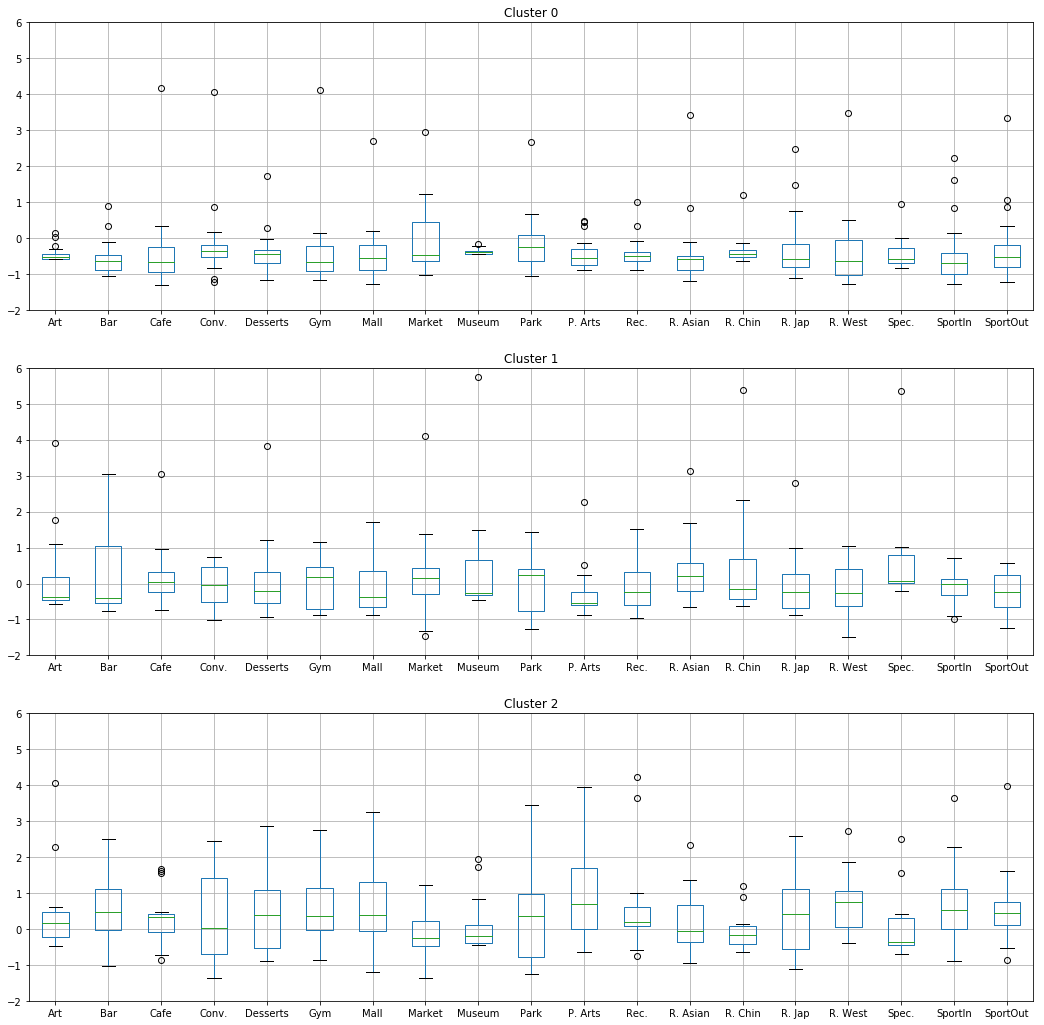

In [91]:
mask0 = df_med['Cluster'] == 0
mask1 = df_med['Cluster'] == 1
mask2 = df_med['Cluster'] == 2


columns2 = ['Art', 'Bar', 'Cafe', 'Conv.', 'Desserts', 'Gym', 'Mall', 'Market', 'Museum', 'Park', 'P. Arts', 'Rec.',
          'R. Asian', 'R. Chin', 'R. Jap', 'R. West', 'Spec.', 'SportIn', 'SportOut']
df.columns = columns2
columns = list(df.columns)
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(18,18),nrows=3)
axes = [ax0, ax1, ax2]
for i in range(len(axes)):
    axes[i].set_ylim(-2, 6)
    axes[i].set_title('Cluster ' + str(i))
df[mask0].boxplot(column = columns, ax = ax0, return_type = 'axes')
df[mask1].boxplot(column = columns, ax = ax1, return_type = 'axes')
df[mask2].boxplot(column = columns, ax = ax2, return_type = 'axes')

We can see some clear distinction between our clusters. Cluster 0 has less (per person) of basically everything, which is consistent with Cluster 0 being composed of more peripheral regions. Cluster 1 and Cluster 2 are similar, but Cluster 2 generally has more venues in most categories, and has significantly more performing arts venues, Western and Japanese Restaurants and indoor sports venues. This supports the characterization of Cluster 1 as being relatively poorer, and Cluster 2 as being relatively richer. It is notable however that all clusters have significant outliers in all categories, and Cluster 1 in particular has some of the most extreme.